To do:

1. Uitleg features (Jassar)
2. 3 clustering modellen kiezen uitleggen, voor- nadelen (Jordan, Casper, Jassar Ieder neemt 1 model en legt deze uit)
3. Cluster model kiezen en toepassen (Met zn allen als 2 klaar is)
4. Vergelijken labeled en niet labeled 
5. “Dimensionality reduction" toepassen en uitleggen
6. hermodelleren
7. Suggestie appje maken (random liedje uit zelfde cluster)

# Kaggle team name: ¿!_xX5Vijf5Xx_!?😎💅🕺🫃

# Members:
1. Jesse Coenraad -> JesseCoenraad
2. Jordan van Sintanneland -> JordanvanSint
3. Casper Priem -> CasperPriem
4. Jassar Hasiba -> UrClades

## Imports

In [115]:
import os
import librosa as lr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio
from pathlib import Path
from librosa.core import stft
from librosa.core import amplitude_to_db
from librosa.display import specshow
import librosa
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#ignore warnings
import warnings 
warnings.filterwarnings('ignore')


In [116]:
labels_new = pd.read_csv('labels_new.csv')

labels_new.head()

,filename,genre
0,m00248.wav,metal
1,m00230.wav,country
2,m00637.wav,hiphop
3,m00627.wav,metal
4,m00138.wav,reggae


# Feature engineering

In [117]:
os.listdir('labeled')

['m00002.wav',
 'm00039.wav',
 'm00041.wav',
 'm00072.wav',
 'm00096.wav',
 'm00102.wav',
 'm00112.wav',
 'm00138.wav',
 'm00192.wav',
 'm00206.wav',
 'm00230.wav',
 'm00236.wav',
 'm00248.wav',
 'm00253.wav',
 'm00298.wav',
 'm00313.wav',
 'm00338.wav',
 'm00339.wav',
 'm00351.wav',
 'm00400.wav',
 'm00421.wav',
 'm00429.wav',
 'm00435.wav',
 'm00454.wav',
 'm00477.wav',
 'm00501.wav',
 'm00503.wav',
 'm00513.wav',
 'm00553.wav',
 'm00606.wav',
 'm00623.wav',
 'm00627.wav',
 'm00629.wav',
 'm00633.wav',
 'm00637.wav',
 'm00658.wav',
 'm00671.wav',
 'm00676.wav',
 'm00677.wav',
 'm00678.wav',
 'm00716.wav',
 'm00762.wav',
 'm00772.wav',
 'm00773.wav',
 'm00801.wav',
 'm00821.wav',
 'm00850.wav',
 'm00867.wav',
 'm00895.wav',
 'm00996.wav']

In [118]:
# Define the base directory where the subdirectories "cat" and "dog" are located
base_dir = "labeled"  # Replace with your directory path

# Initialize lists for audio data and labels
audio_data = []
sample_freqs = []
labels = []

# Target length for 5 seconds at a sample rate of 22050 Hz (adjust if different)
target_length = 5 * 22050

# Process each audio file
for label in labels_new['filename']:
    sub_dir = os.path.join(base_dir)
    for file in os.listdir(sub_dir):
        if file.endswith(".wav"):
            file_path = os.path.join(sub_dir, file)
            data, sfreq = lr.load(file_path, sr=None)  # Keep original sample rate

            # Truncate or pad the audio
            if len(data) > target_length:
                # Truncate the data
                data = data[:target_length]
            elif len(data) < target_length:
                # Pad with zeros
                padding = target_length - len(data)
                data = np.pad(data, (0, padding), mode='constant')

            # Append the processed data and label
            audio_data.append(data)
            sample_freqs.append(sfreq)
            labels.append(label)

audio_data = np.stack(audio_data, axis=0)
sample_freqs = np.array(sample_freqs)
labels = np.array(labels)

In [119]:
print(audio_data[:5], labels[:5])

[[-0.01635742 -0.02282715 -0.01467896 ...  0.00747681  0.00817871
   0.00772095]
 [-0.0947876  -0.15338135 -0.1439209  ... -0.18804932 -0.09313965
  -0.0645752 ]
 [ 0.07803345 -0.03765869  0.12664795 ...  0.06295776  0.0484314
   0.02236938]
 [ 0.1060791   0.08496094  0.06210327 ...  0.27041626  0.321167
   0.26272583]
 [-0.03607178 -0.10568237 -0.20123291 ... -0.05239868 -0.0506897
  -0.05014038]] ['m00248.wav' 'm00248.wav' 'm00248.wav' 'm00248.wav' 'm00248.wav']


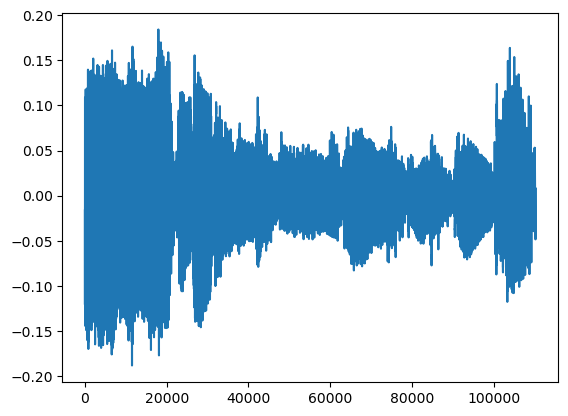

In [120]:
plt.plot(audio_data[0])

In [121]:
# Pick a random audio clip
random_index = np.random.choice(len(audio_data), size=1, replace=False)
clip = audio_data[random_index][0]
sfreq = sample_freqs[random_index][0]
label = labels[random_index][0]

print(f"Label {label}")

# Play the clip
Audio(data=clip, rate=sfreq)

Label m00996.wav


In [122]:
def calculate_spectrograms(audio_clips, n_fft=2048, hop_length=512, win_length=None):
    """
    Calculate the spectrogram for each audio clip in the audio_clips array.

    Parameters:
    - audio_clips: A list of audio clips (numpy arrays).
    - n_fft: The number of data points used in each block for the FFT (default 2048).
    - hop_length: The number of samples between successive frames (default 512).
    - win_length: The window size (default is `n_fft`).

    Returns:
    - spectrograms: A list of spectrograms corresponding to each audio clip.
    - spec_db: The spectrograms in decibels, for plotting
    """
    spectrograms = []
    spectrograms_db = []

    for clip in audio_clips:
        win_length = win_length or n_fft

        # Calculate the STFT. Use lr.stft() here.
        stft_matrix = stft(clip, n_fft=n_fft, hop_length=hop_length, win_length=win_length)



        # Calculate the magnitude of the STFT (spectrogram). Use np.abs() here.
        spectrogram = np.abs(stft_matrix)



        # Convert to decibels. Use amplitude_to_db() here.
        deci = amplitude_to_db(spectrogram, ref=np.max)


        # Append the spectrogram to the list
        spectrograms.append(spectrogram)



        # Append spectrogram in decibels to the list
        spectrograms_db.append(deci)



    return spectrograms, spectrograms_db

# Use function
spectrograms, spectrograms_db = calculate_spectrograms(audio_data, n_fft=2048, hop_length=512, win_length=None)



Label m00553.wav


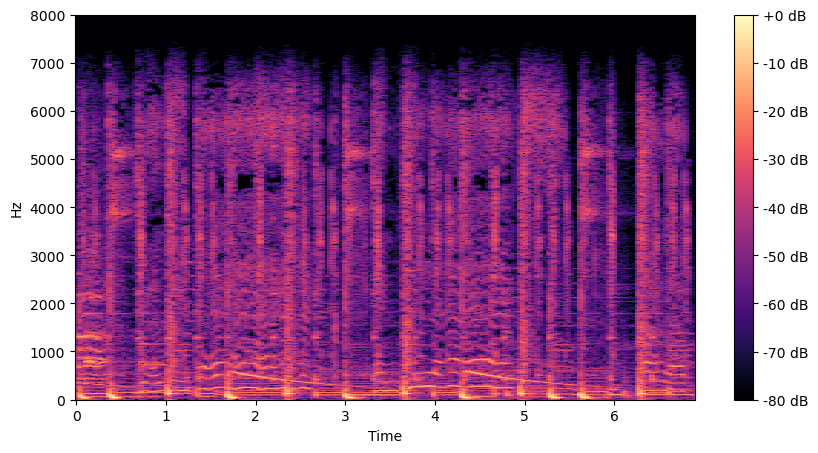

In [123]:
# Pick a random spectrogram
random_index = np.random.choice(len(spectrograms_db), size=1, replace=False)
spectrogram = spectrograms_db[random_index[0]]
clip = audio_data[random_index][0]
sfreq = sample_freqs[random_index][0]
label = labels[random_index][0]

print(f"Label {label}")

# Display the spectrogram
plt.figure(figsize=(10, 5))
img = specshow(spectrogram, x_axis='time', y_axis='hz', sr=16000, hop_length=512)
plt.colorbar(img, format='%+2.0f dB')
plt.show()

# Play the corresponding clip
Audio(data=clip, rate=sfreq)

In [124]:
def calculate_spectral_features(spectrograms):
    """
    Calculate the centroid and bandwidth for each spectrogram in a list.

    Parameters:
    - spectrograms: A list of spectrograms.

    Returns:
    - bandwidths: A list of bandwidths corresponding to each spectrogram
    - centroids: A list of centroids corresponding to each spectrogram
    """
    bandwidths = []
    centroids = []

    for spectrogram in spectrograms:

        # Calculate the bandwidth for the spectrogram (use lr.feature.spectral_bandwidth)
        bandwidths.append(lr.feature.spectral_bandwidth(S=spectrogram))



        # Calculate the spectral centroid for the spectrogram (use lr.feature.spectral_centroid)
        centroids.append(lr.feature.spectral_centroid(S=spectrogram))



    return bandwidths, centroids

# Use function
bandwidths, centroids = calculate_spectral_features(spectrograms)

Label m00503.wav


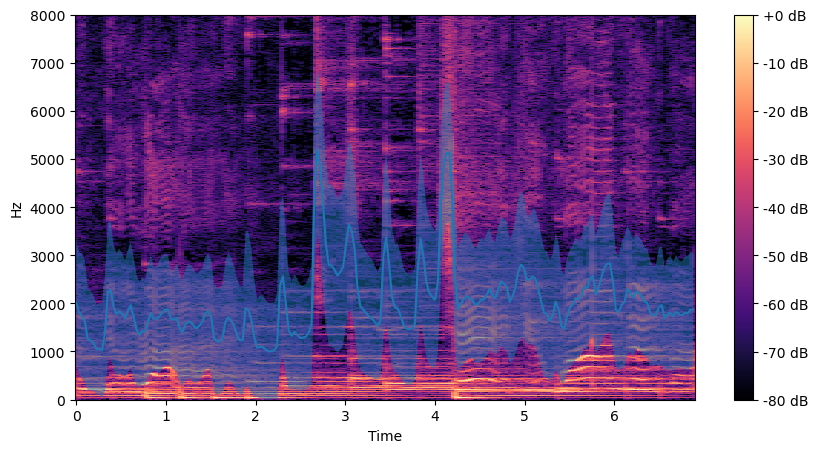

In [125]:
# Pick a random spectrogram
random_index = np.random.choice(len(spectrograms_db), size=1, replace=False)
spectrogram = spectrograms_db[random_index[0]]

# Get time index values
times_spec = lr.frames_to_time(range(spectrogram.shape[1]), sr=16000, hop_length=512)

bw = bandwidths[random_index[0]][0]
cent = centroids[random_index[0]][0]

clip = audio_data[random_index][0]
sfreq = sample_freqs[random_index][0]
label = labels[random_index][0]

print(f"Label {label}")

# Display the spectrogram
plt.figure(figsize=(10, 5))
img = specshow(spectrogram, x_axis='time', y_axis='hz', sr=16000, hop_length=512)
plt.plot(times_spec, cent)
plt.fill_between(times_spec, cent - bw / 2, cent + bw / 2, alpha=.5)
plt.colorbar(img, format='%+2.0f dB')
plt.show()

# Play the corresponding clip
Audio(data=clip, rate=sfreq)


## feature creation

In [126]:
# Function to extract spectral features from an audio file
#def extract_spectral_features(audio_file, sr=22050):
#    try:
#        # Load the audio file
#        y, sr = librosa.load(audio_file, sr=sr)
#        
#        # Spectral Features
#        features = {}
#
#        # MFCCs
#        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
#        features['mfcc_mean'] = np.mean(mfccs, axis=1)
#        features['mfcc_var'] = np.var(mfccs, axis=1)
#
#        # Feature Trajectories
#        mfcc_delta = librosa.feature.delta(mfccs)
#        features['mfcc_delta_mean'] = np.mean(mfcc_delta, axis=1)
#        features['mfcc_delta_var'] = np.var(mfcc_delta, axis=1)
#        
#        # Spectral Centroid
#        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
#        features['spectral_centroid_mean'] = np.mean(spectral_centroid)
#        features['spectral_centroid_var'] = np.var(spectral_centroid)
#        
#        # Spectral Roll-off
#        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)
#        features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
#        features['spectral_rolloff_var'] = np.var(spectral_rolloff)
#        
#        # Spectral Flux
#        spectral_flux = librosa.onset.onset_strength(y=y, sr=sr)
#        features['spectral_flux_mean'] = np.mean(spectral_flux)
#        features['spectral_flux_var'] = np.var(spectral_flux)
#        
#        # Spectral Contrast
#        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
#        features['spectral_contrast_mean'] = np.mean(spectral_contrast, axis=1)
#        features['spectral_contrast_var'] = np.var(spectral_contrast, axis=1)
#
#        envelope = np.abs(y)
#        features['envelope_mean'] = np.mean(envelope)
#        features['envelope_var'] = np.var(envelope)
#
#        # Spectral Bandwidth
#        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
#        features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
#        features['spectral_bandwidth_var'] = np.var(spectral_bandwidth)
#
#        # Time-Domain Features
#        features['rms_mean'] = np.mean(librosa.feature.rms(y=y))
#        features['rms_var'] = np.var(librosa.feature.rms(y=y))
#        features['energy'] = np.sum(y ** 2) / len(y)  # Signal energy
#        features['amplitude_mean'] = np.mean(np.abs(y))
#        features['amplitude_var'] = np.var(np.abs(y))
#
#        # Temporal Evolution
#        dynamic_range = np.max(y) - np.min(y)
#        features['dynamic_range'] = dynamic_range
#
#        # Rhythm Features
#        tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
#        features['tempo'] = tempo
#        beat_strength = librosa.onset.onset_strength(y=y, sr=sr)
#        features['beat_strength_mean'] = np.mean(beat_strength)
#        features['beat_strength_var'] = np.var(beat_strength)
#
#        # Rhythmic Regularity
#        if len(beat_frames) > 1:
#            # Inter-Beat Interval (IBI) Variability
#            ibi = np.diff(beat_frames) / sr  # Convert frame difference to seconds
#            features['ibi_var'] = np.var(ibi)
#            features['ibi_mean'] = np.mean(ibi)
#
#        # Harmonic Features
#        # Key and Scale Estimation
#        chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
#        features['chroma_mean'] = np.mean(chroma, axis=1)
#        features['chroma_var'] = np.var(chroma, axis=1)
#        
#        # Tonnetz
#        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
#        features['tonnetz_mean'] = np.mean(tonnetz, axis=1)
#        features['tonnetz_var'] = np.var(tonnetz, axis=1)
#
#        # Harmonic-to-Percussive Ratio
#        harmonic, percussive = librosa.effects.hpss(y)
#        hpr = np.mean(harmonic) / (np.mean(percussive) + 1e-6)
#        features['hpr'] = hpr
#
#        # Genre-Specific Features
#        # Harmonic and Percussive Energy
#        features['harmonic_energy'] = np.sum(harmonic ** 2)
#        features['percussive_energy'] = np.sum(percussive ** 2)
#
#        # Zero-Crossing Rate
#        zcr = librosa.feature.zero_crossing_rate(y)
#        features['zcr_mean'] = np.mean(zcr)
#        features['zcr_var'] = np.var(zcr)
#
#        # Onset Autocorrelation (Rhythmic Regularity)
#        onset_acf = librosa.autocorrelate(librosa.onset.onset_strength(y=y, sr=sr), max_size=len(y)//2)
#        features['onset_acf_mean'] = np.mean(onset_acf)
#        features['onset_acf_var'] = np.var(onset_acf)
#
#        # Statistics (Skewness and Kurtosis)
#        features['skewness'] = skew(y)
#        features['kurtosis'] = kurtosis(y)
#
#
#        
#        return features
#    except Exception as e:
#        print(f"Error processing {audio_file}: {e}")
#        return None
#
#
#
#
## Function to process all files in a folder
#def process_audio_folder(folder_path, output_csv="audio_features.csv"):
#    feature_list = []
#    file_names = []
#
#    # Loop through all files in the folder
#    for file_name in os.listdir(folder_path):
#        # Check if the file is a valid audio file
#        if file_name.endswith(('.wav', '.mp3', '.flac', '.ogg')):
#            file_path = os.path.join(folder_path, file_name)
#            print(f"Processing file: {file_name}")
#            
#            # Extract features
#            features = extract_spectral_features(file_path)
#            
#            if features:
#                # Flatten features and add file name
#                flat_features = {}
#                for key, value in features.items():
#                    if isinstance(value, np.ndarray):
#                        for i, val in enumerate(value):
#                            flat_features[f"{key}_{i}"] = val
#                    elif isinstance(value, list):
#                        for i, val in enumerate(value):
#                            flat_features[f"{key}_{i}"] = val
#                    else:
#                        flat_features[key] = value
#                
#                flat_features['file_name'] = file_name
#                feature_list.append(flat_features)
#
#    # Convert to DataFrame
#    df = pd.DataFrame(feature_list)
#
#    # Save to CSV
#    df.to_csv(output_csv, index=False)
#    print(f"Features saved to {output_csv}")
#
#
#
#if __name__ == "__main__":
#    # Path to your folder containing audio files
#    folder_path = "labeled"
#    
#    # Process folder and save features to CSV
#    process_audio_folder(folder_path, output_csv="audio_features_labeled.csv")
#
#if __name__ == "__main__":
#    # Path to your folder containing audio files
#    folder_path = "unlabeled"
#    
#    # Process folder and save features to CSV
#    process_audio_folder(folder_path, output_csv="audio_features_unlabeled.csv")


In [127]:
audio_features_labeled = pd.read_csv('audio_features_labeled.csv')
audio_features_unlabeled = pd.read_csv('audio_features_unlabeled.csv')

In [128]:
# Set max columns
pd.set_option('display.max_columns', None)

In [129]:
display(audio_features_labeled.head())
display(audio_features_unlabeled.head())

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,mfcc_mean_11,mfcc_mean_12,mfcc_var_0,mfcc_var_1,mfcc_var_2,mfcc_var_3,mfcc_var_4,mfcc_var_5,mfcc_var_6,mfcc_var_7,mfcc_var_8,mfcc_var_9,mfcc_var_10,mfcc_var_11,mfcc_var_12,mfcc_delta_mean_0,mfcc_delta_mean_1,mfcc_delta_mean_2,mfcc_delta_mean_3,mfcc_delta_mean_4,mfcc_delta_mean_5,mfcc_delta_mean_6,mfcc_delta_mean_7,mfcc_delta_mean_8,mfcc_delta_mean_9,mfcc_delta_mean_10,mfcc_delta_mean_11,mfcc_delta_mean_12,mfcc_delta_var_0,mfcc_delta_var_1,mfcc_delta_var_2,mfcc_delta_var_3,mfcc_delta_var_4,mfcc_delta_var_5,mfcc_delta_var_6,mfcc_delta_var_7,mfcc_delta_var_8,mfcc_delta_var_9,mfcc_delta_var_10,mfcc_delta_var_11,mfcc_delta_var_12,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var,spectral_flux_mean,spectral_flux_var,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_contrast_var_0,spectral_contrast_var_1,spectral_contrast_var_2,spectral_contrast_var_3,spectral_contrast_var_4,spectral_contrast_var_5,spectral_contrast_var_6,envelope_mean,envelope_var,spectral_bandwidth_mean,spectral_bandwidth_var,rms_mean,rms_var,energy,amplitude_mean,amplitude_var,dynamic_range,tempo_0,beat_strength_mean,beat_strength_var,ibi_var,ibi_mean,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,chroma_var_0,chroma_var_1,chroma_var_2,chroma_var_3,chroma_var_4,chroma_var_5,chroma_var_6,chroma_var_7,chroma_var_8,chroma_var_9,chroma_var_10,chroma_var_11,tonnetz_mean_0,tonnetz_mean_1,tonnetz_mean_2,tonnetz_mean_3,tonnetz_mean_4,tonnetz_mean_5,tonnetz_var_0,tonnetz_var_1,tonnetz_var_2,tonnetz_var_3,tonnetz_var_4,tonnetz_var_5,hpr,harmonic_energy,percussive_energy,zcr_mean,zcr_var,onset_acf_mean,onset_acf_var,skewness,kurtosis,file_name
0,-298.75613,112.07628,6.488818,28.389170,-6.770987,16.645588,-11.807551,12.744363,-8.340971,13.893223,-4.237726,2.317613,-4.329583,1554.9755,390.28247,320.89825,105.76838,101.059784,61.902504,82.039276,48.866817,47.399956,64.280260,111.890610,126.388306,120.863950,0.005839,0.004812,0.020788,0.015165,0.001272,0.004242,0.012779,0.001703,-0.000209,-0.009065,-0.006804,-0.001605,0.008666,36.538918,6.454208,5.229606,2.149433,2.356934,1.565208,1.127039,1.024333,0.937488,0.991976,1.198937,1.430932,1.097868,1451.862124,183985.425689,3047.431199,1.842019e+06,1.019220,1.012064,19.667917,20.515668,26.072390,25.745788,23.396068,19.541724,34.600593,24.517215,32.670781,31.555140,25.556302,17.636078,7.324131,6.284332,0.041394,0.001573,1920.270843,124234.979685,0.050480,0.000736,0.003287,0.041394,0.001573,0.681824,129.199219,1.019220,1.012064,2.275957e-09,0.000914,0.293050,0.298951,0.432657,0.366545,0.314283,0.318708,0.276418,0.322159,0.446124,0.322144,0.202407,0.229390,0.060446,0.051617,0.112050,0.068877,0.062176,0.090679,0.059014,0.091233,0.121262,0.089204,0.039807,0.057091,0.008745,0.028968,-0.004044,0.020831,-0.043709,-0.007959,0.063368,0.026762,0.039468,0.054027,0.008510,0.005773,0.304814,2037.1526,39.70027,0.051224,0.000629,672.615952,1.643258e+05,0.088488,2.617145,m00002.wav
1,-169.15335,110.46000,-8.576200,43.884247,0.274970,26.637419,-14.368152,13.034431,-11.149249,8.130109,-7.692966,10.910651,-8.175924,5892.5620,1215.42640,493.89438,327.86285,245.584200,143.999300,259.719700,129.647030,166.339250,120.264595,102.962370,78.158070,92.049706,0.056805,-0.018237,-0.018925,0.003801,-0.001256,0.001814,0.000077,-0.008677,-0.010297,-0.009070,0.005973,0.010871,-0.000483,213.430250,34.695606,15.847273,9.308044,6.993538,3.901713,6.591294,3.835872,4.565116,3.650020,2.752775,2.039738,2.522136,1811.410394,655731.637154,3854.851374,2.880615e+06,1.823281,7.378284,19.964829,17.050832,21.109923,19.301231,20.553355,18.597363,38.304349,30.914

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,mfcc_mean_11,mfcc_mean_12,mfcc_var_0,mfcc_var_1,mfcc_var_2,mfcc_var_3,mfcc_var_4,mfcc_var_5,mfcc_var_6,mfcc_var_7,mfcc_var_8,mfcc_var_9,mfcc_var_10,mfcc_var_11,mfcc_var_12,mfcc_delta_mean_0,mfcc_delta_mean_1,mfcc_delta_mean_2,mfcc_delta_mean_3,mfcc_delta_mean_4,mfcc_delta_mean_5,mfcc_delta_mean_6,mfcc_delta_mean_7,mfcc_delta_mean_8,mfcc_delta_mean_9,mfcc_delta_mean_10,mfcc_delta_mean_11,mfcc_delta_mean_12,mfcc_delta_var_0,mfcc_delta_var_1,mfcc_delta_var_2,mfcc_delta_var_3,mfcc_delta_var_4,mfcc_delta_var_5,mfcc_delta_var_6,mfcc_delta_var_7,mfcc_delta_var_8,mfcc_delta_var_9,mfcc_delta_var_10,mfcc_delta_var_11,mfcc_delta_var_12,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var,spectral_flux_mean,spectral_flux_var,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_contrast_var_0,spectral_contrast_var_1,spectral_contrast_var_2,spectral_contrast_var_3,spectral_contrast_var_4,spectral_contrast_var_5,spectral_contrast_var_6,envelope_mean,envelope_var,spectral_bandwidth_mean,spectral_bandwidth_var,rms_mean,rms_var,energy,amplitude_mean,amplitude_var,dynamic_range,tempo_0,beat_strength_mean,beat_strength_var,ibi_var,ibi_mean,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,chroma_var_0,chroma_var_1,chroma_var_2,chroma_var_3,chroma_var_4,chroma_var_5,chroma_var_6,chroma_var_7,chroma_var_8,chroma_var_9,chroma_var_10,chroma_var_11,tonnetz_mean_0,tonnetz_mean_1,tonnetz_mean_2,tonnetz_mean_3,tonnetz_mean_4,tonnetz_mean_5,tonnetz_var_0,tonnetz_var_1,tonnetz_var_2,tonnetz_var_3,tonnetz_var_4,tonnetz_var_5,hpr,harmonic_energy,percussive_energy,zcr_mean,zcr_var,onset_acf_mean,onset_acf_var,skewness,kurtosis,file_name
0,-82.511116,97.341720,-34.367928,71.408500,-3.292029,17.375370,-9.026282,16.017792,-19.010939,12.084585,-9.567408,13.953283,-14.459843,1495.31340,323.14224,303.47400,188.579220,86.017350,84.597060,84.94236,58.439934,60.750860,45.940710,54.467407,56.921330,49.913574,0.032332,-0.011551,0.019673,0.005145,-0.005075,0.010663,-0.012069,0.010063,-0.013004,0.008569,-0.008988,0.004900,-0.001533,66.146390,11.528210,10.818743,5.622297,2.679742,3.041711,2.995004,2.419857,2.057163,1.708135,1.678801,1.847640,1.650308,2254.606986,181485.103346,4381.532206,6.812328e+05,1.266915,1.968874,18.423249,14.811132,17.832926,16.011167,16.647809,18.873513,40.065721,11.395035,15.969185,16.394511,9.435377,7.140561,10.664836,9.504874,0.107064,0.008540,2071.028440,65546.963984,0.136221,0.001426,0.020003,0.107064,0.008540,1.441528,135.999178,1.266915,1.968874,5.744313e-10,0.000883,0.529348,0.448068,0.449999,0.381931,0.623449,0.615237,0.553252,0.573993,0.579249,0.728674,0.594404,0.785671,0.032566,0.034395,0.028024,0.022643,0.038556,0.036440,0.025989,0.044005,0.033090,0.059310,0.028562,0.067450,0.063834,-0.022262,-0.006882,0.019403,-0.012761,-0.009527,0.001581,0.002258,0.007670,0.003210,0.000827,0.000790,0.474129,5015.80270,4307.202600,0.120116,0.001477,1039.467137,527389.560386,0.050494,1.502084,m00003.wav
1,-1.913298,72.686160,-32.791992,63.605476,-18.556350,25.870161,-13.859100,18.078884,-11.946615,19.672184,-13.954248,18.755697,-11.187991,477.82126,305.40076,242.78651,111.447070,69.674230,64.006805,79.26658,55.608890,54.374500,47.221706,45.175900,52.288517,39.032050,0.043845,-0.035664,0.022582,0.007591,0.009378,-0.012955,-0.011197,0.020559,-0.001235,0.016232,0.008010,0.014450,0.006791,9.078316,5.447008,7.454595,3.213688,2.712893,2.267431,2.836614,1.768919,2.231687,1.811514,1.813684,1.852286,1.229471,2908.300131,153812.037753,5405.816551,6.232725e+05,1.156346,0.539575,18.524161,13.818721,18.002752,15.368700,15.475696,17.230423,41.887691,20.743

### Feature reasoning first pass

#### **MFCCs (Mel-Frequency Cepstral Coefficients)**
-   **TLDR**: MFCCs transform raw audio into a compact representation aligned with human perception. By summarizing frequency content with a perceptual emphasis, they excel at distinguishing timbral differences—an essential characteristic for clustering and classifying music genres.

**What It Does:**
- MFCCs encode the spectral envelope of a sound, summarizing the timbral texture and frequency content in a compact form. 
- These coefficients are derived from the Mel scale, which is a perceptual scale of pitches designed to approximate how the human ear interprets frequencies.

**Why Useful:**
- **Timbral characteristics** are key indicators of musical genre. For instance:
    - Classical music tends to have smooth, consistent MFCC patterns due to its harmonic richness and lack of sharp transients.
    - Hip-hop often exhibits sharp MFCC variations, reflecting its percussive beats and dynamic changes.
    - MFCCs reduce the high-dimensional frequency information of audio into a smaller, meaningful representation that aligns well with human auditory perception, making them especially valuable for clustering and genre classification tasks.

**How MFCCs Are Constructed:**

1. **Frame the Signal:**
    - Audio signals are processed in small, overlapping frames (e.g., 25ms long) because sound properties change over time. 
    - A Hamming window is often applied to each frame to reduce edge artifacts.
     $$
     w(n) = 0.54 - 0.46 \cdot \cos\left(\frac{2\pi n}{N-1}\right)
     $$

2. **Convert to the Frequency Domain (FFT):**
    - Apply the Fast Fourier Transform (FFT) to each frame to break it into its frequency components.
     $$
     X(k) = \sum_{n=0}^{N-1} x(n) \cdot e^{-j \cdot 2\pi \cdot k \cdot n / N}
     $$
    - This gives the magnitude spectrum, showing how much energy exists at each frequency.

3. **Apply the Mel Scale:**
    - The human ear is more sensitive to changes in low frequencies than high frequencies. The Mel scale models this perception by warping the frequency axis:
     $$
     m(f) = 2595 \cdot \log_{10}(1 + \frac{f}{700})
     $$
    - The frequency spectrum is then divided into a series of overlapping Mel filter banks (triangular filters), each capturing energy in a specific range of frequencies.

4. **Compute Filter Bank Energies:**
    - Multiply the magnitude spectrum by the Mel filter bank weights and sum the results for each filter to get a set of Mel-scaled energies:
     $$
     E_m = \sum_{k=0}^{N-1} |X(k)|^2 \cdot H_m(k)
     $$
    - Hm(k): The Mel filter bank response for filter m.

5. **Logarithmic Compression:**
    - Apply a logarithm to the Mel-scaled energies to mimic the human ear's logarithmic perception of loudness:
     $$
     \log(E_m)
     $$

6. **Apply the Discrete Cosine Transform (DCT):**
    - The final step is to apply the*DCT to the log Mel energies. This decorrelates the features and compresses the data, leaving only the most important coefficients:
     $$
     C_n = \sum_{m=0}^{M-1} \log(E_m) \cdot \cos\left(\frac{\pi n (2m+1)}{2M}\right)
     $$
    - The result is the Mel-Frequency Cepstral Coefficients (MFCCs), with the first few coefficients typically carrying most of the useful information.

Valerio Velardo - The Sound of AI. (2020, October 5). Mel-Frequency cepstral coefficients explained easily [Video]. YouTube. https://www.youtube.com/watch?v=4_SH2nfbQZ8

Deruty, E. (2022, December 15). Intuitive understanding of MFCCs - Emmanuel Deruty - Medium. Medium. https://medium.com/@derutycsl/intuitive-understanding-of-mfccs-836d36a1f779



---

#### **Feature Trajectories (MFCC Delta)**
- **TLDR**: MFCC deltas extend the static timbral representation of MFCCs by introducing a temporal component, making them particularly useful for genres characterized by dynamic soundscapes or rhythmic complexity. The mathematical approach is straightforward, involving a sliding window to measure temporal changes while balancing sensitivity and smoothness. Though potentially less impactful for short, static clips, they remain a valuable feature in clustering tasks where temporal variation matters.

**What It Does:**
- MFCC deltas (or first-order derivatives) measure how MFCC values change over time, capturing the temporal dynamics of timbral features.
- While MFCCs summarize the spectral envelope of a sound at a single point in time, MFCC deltas provide insights into the rate and nature of change in the sound's timbral qualities.

**Why Useful:**
- Dynamic changes in timbre can be strong indicators of musical genre:
  - Jazz or classical music might exhibit smooth, continuous variations, reflecting evolving instrumentation and harmonic progressions.
  - pop music, on the other hand, could have more abrupt, repetitive changes due to beat-driven transitions or drops.
- Even within 30-second clips, deltas may reveal rhythmic complexity or transitions in instrumentation.
- However, in cases where the clips are highly static or lack significant variation, MFCC deltas might contribute less to distinguishing genres.

**How MFCC Deltas Are Constructed:**

1. **Input Data:**
   - Start with the matrix of MFCCs, where each row represents a specific coefficient, and each column corresponds to a time frame.

2. **Compute Temporal Differences:**
   - Deltas are calculated using finite differences over a sliding window of frames:
     $$
     \Delta C(t) = \frac{\sum_{\tau=-T}^T \tau \cdot C(t+\tau)}{\sum_{\tau=-T}^T \tau^2}
     $$
     - C(t): MFCC coefficient at time t.
     - T: Size of the time window for delta computation.
   - In essence, this formula computes a weighted average of differences between MFCC values in neighboring frames, emphasizing larger temporal changes while smoothing out noise.

3. **Smoothing and Noise Reduction:**
   - The size of the sliding window (T) determines the smoothness of the delta values:
     - A small window captures rapid changes but may be noisy.
     - A larger window smooths out noise but might miss finer details in the dynamics.

DataMListic. (2023, February 1). Spectral features - Deltas and Delta-Deltas explained [Video]. YouTube. https://www.youtube.com/watch?v=zxEnuPolylY

---

#### **Spectral Centroid**
- **TLDR**: Spectral centroids provide a compact representation of the frequency content's distribution, offering valuable insights into timbral brightness and genre-related characteristics. The math is intuitive, relying on a weighted average that highlights the dominant frequency regions in the spectrum. This makes it a powerful feature for clustering and classification tasks in music analysis.

**What It Does:**
- The spectral centroid measures the "center of mass" of a sound’s frequency spectrum.
- It provides a numerical value that reflects the brightness of a sound:
  - Higher values correspond to brighter, sharper sounds dominated by higher frequencies (e.g., cymbals, electric guitars).
  - Lower values correspond to darker, mellower sounds dominated by lower frequencies (e.g., bass, cello).

**Why Useful:**
- Genre differentiation: Brighter genres like rock tend to have higher spectral centroids, whereas smoother genres like jazz or classical may lean toward lower values.
- Timbre characterization: Brightness is a key aspect of timbre, helping to distinguish instruments and production styles.

**How Spectral Centroids Are Constructed:**

1. Input Data:
   - Start with the power spectrum of the audio signal:
     $$
     S(f)
     $$
     - S(f): Magnitude of the signal at frequency f.
     - This is obtained by applying the Short-Time Fourier Transform (STFT) to the time-domain signal, which decomposes the signal into its frequency components over time.

2. **Compute the Centroid:**
   - The spectral centroid for each frame (time slice) is calculated as a weighted average of the frequencies, using the magnitude of each frequency as the weight:
     $$
     C = \frac{\sum_{f} f \cdot S(f)}{\sum_{f} S(f)}
     $$
     - f: Frequency (in Hz).
     - S(f): Magnitude at frequency f.
   - The numerator sums the product of each frequency and its corresponding magnitude, while the denominator normalizes the result by the total energy in the spectrum.

3. **Interpretation:**
   - The result, C, is the frequency (in Hz) that represents the "center of mass" of the spectrum.
   - A higher C indicates that the majority of the spectral energy lies in the upper frequencies, while a lower C indicates concentration in the lower frequencies.

4. **Temporal Aggregation:**
   - To summarize spectral centroids over the entire audio clip:
     - Mean: Represents the overall brightness of the clip.
     - Variance: Indicates the variability in brightness, which may correspond to dynamic changes in instrumentation or mixing.

**Example:**
Imagine a sound with:
- A strong peak at 100 Hz (low frequency) with magnitude 10.
- A smaller peak at 5000 Hz (high frequency) with magnitude 2.

The spectral centroid would be closer to 100 Hz because the lower frequency dominates the spectrum.

---

#### **Spectral Roll-Off**
- **TLDR**: Spectral roll-off captures how spectral energy is distributed across frequencies, making it valuable for understanding the "cut-off point" of energy in audio signals. Its mathematical simplicity—relying on cumulative sums and percentages—belies its utility in differentiating between genres, timbres, and instrumentation.

**What It Does:**
- The spectral roll-off represents the frequency boundary below which a specified percentage of the total spectral energy resides. 
- It is currently calculated at 85%, meaning it identifies the frequency below which 85% of the cumulative energy in the spectrum lies.
- This feature helps distinguish between high-energy sounds, with energy distributed across higher frequencies (e.g., pop), and low-energy sounds, where energy is more concentrated in lower frequencies (e.g., classical).


**Why Useful:**
- Genre differentiation: High-energy genres like rock often have higher roll-off values due to significant high-frequency content, while smoother genres like jazz have lower roll-off values.
- Instrumental texture: Instruments like cymbals or electric guitars contribute high-frequency energy, raising the roll-off point. Conversely, instruments like double basses or tubas lower it.
- Timbre analysis: It complements other spectral features (e.g., spectral centroid (see above)) in capturing the distribution of energy across the spectrum.


**How Spectral Roll-Off Is Constructed:**

1. **Input Data:**
   - Use the power spectrum, S(f), from the Short-Time Fourier Transform (STFT):
     - S(f): Magnitude of the signal at each frequency f.

2. **Cumulative Energy Calculation:**
   - Compute the **cumulative sum** of spectral energy up to each frequency f:
     $$
     E_{\text{cumulative}}(f) = \sum_{i=0}^{f} S(f_i)
     $$
     - Ecumulative(f): Total energy in the spectrum up to frequency f.
     - This provides a running total of the energy distribution.

3. **Find Roll-Off Frequency:**
   - Identify the frequency frolloff where the cumulative energy reaches a specified percentage p (e.g., 85%) of the total energy:
     $$
     E_{\text{cumulative}}(f_{\text{rolloff}}) = p \cdot E_{\text{total}}
     $$

     $$
      E_{\text{total}} = \sum_{i=0}^{F} S(f_i) 
     $$ 
    - the total energy in the spectrum.
   - Mathematically, frolloff satisfies:
     $$
     f_{\text{rolloff}} = \min \{ f \, | \, E_{\text{cumulative}}(f) \geq p \cdot E_{\text{total}} \}
     $$

4. **Temporal Aggregation:**
   - To summarize the roll-off over an entire audio clip:
     - Mean: The average roll-off frequency across time frames, indicating the overall spectral boundary.
     - Variance: The variability of roll-off frequencies, reflecting how much the energy distribution changes over time.

**Example:**
Suppose a signal has total spectral energy distributed as follows:
- 100 Hz: 50 units of energy
- **200 Hz: 30 units of energy
- 300 Hz: 20 units of energy
- 400 Hz: 10 units of energy

The total energy is 50 + 30 + 20 + 10 = 110 . For an 85% roll-off:
- 85% of 110 = 93.5.
- Adding energy cumulatively:
  - At 100 Hz: 50  (too low).
  - At 200 Hz: 50 + 30 = 80 (still too low).
  - At 300 Hz: 50 + 30 + 20 = 100 (exceeds 93.5).

Thus, the roll-off frequency is approximately 300 Hz.

---

**Spectral Flux**
- **TLDR**: By analyzing spectral flux across a track, we gain insight into the temporal dynamism of a piece, which is a key characteristic for clustering music into genres.
    - High flux values indicate rapid changes in spectral content, such as sudden instrument attacks, beats, or note transitions.
    - Low flux values suggest sustained tones, continuous sounds, or gradual transitions.

**What It Does:**
- Spectral flux measures the rate of change in the power spectrum across successive time frames.
- It captures how dynamic or stable the sound is over time. Rapid spectral changes are common in genres like hip-hop, whereas smoother transitions are more typical of classical.

**Why Useful:**
- Genre Differentiation: High spectral flux values indicate fast-changing spectral content, which is characteristic of genres with frequent note or beat changes, such as hip-hop or EDM. Lower flux values reflect more sustained, stable sounds, like those in ambient or classical genres.
- Rhythmic Complexity: Tracks with intricate rhythms or beatswitches produce noticeable spectral variations, leading to higher flux values.
- Dynamic Textures: Helps detect changes in timbre or instrumentation, such as the transition from a quiet passage to a sudden loud section.

**How Spectral Flux Is Constructed:**

1. **Input Data:**
   - Start with the Short-Time Fourier Transform (STFT), which splits the audio signal into overlapping frames and computes the spectrum for each frame:
     $$
     S(t, f): \text{The power spectrum at time } t \text{ and frequency } f.
     $$

2. **Compute Frame-to-Frame Differences:**
   - Measure how the spectrum changes between consecutive frames. The flux at time t is given by:
     $$
     \text{Flux}(t) = \sum_{f} \left( S(t, f) - S(t-1, f) \right)^2
     $$
     - This is a squared difference, ensuring that both increases and decreases in spectral values contribute equally to the flux.

3. **Normalization (Optional):**
   - To focus on relative changes rather than absolute magnitudes, normalize the spectrum:
     $$
     \text{Normalized Spectrum}(t, f) = \frac{S(t, f)}{\sum_{f} S(t, f)}.
     $$
     - This ensures that variations are not dominated by the overall energy in the signal.

4. **Aggregate Across Frames:**
   - The result is a time series of flux values, where each value represents the spectral change between two consecutive frames.


---

#### **Spectral Contrast**
- **TLDR**: By analyzing spectral contrast, we gain insights into the tonal and dynamic structure of music, which plays a crucial role in unsupervised clustering of genres. Spectral contrast effectively highlights differences in instrumentation, harmonic complexity, and texture that are often unique to specific musical styles.
    - High Spectral Contrast:
        - Indicates a wide dynamic range within the frequency bands.
        - Found in genres like jazz, where instruments produce distinct tonal peaks and quieter gaps between notes.
    - Low Spectral Contrast:
        - Suggests evenly distributed spectral energy.

**What It Does:**
- Spectral contrast measures the difference in energy levels between peaks (high-energy regions) and valleys (low-energy regions) within different frequency bands of the spectrum.
- It provides a representation of the tonal texture and harmonic richness of the audio.

 **Why Useful:**
- Texture and Complexity: Genres with complex instrumentation and harmonic variation, such as jazz or classical, tend to exhibit higher spectral contrast, as there are pronounced differences between the harmonic peaks (e.g., instruments) and quieter background frequencies.
- Minimalist Genres: Simpler genres like ambient or drone music often have lower spectral contrast because their spectral energy is more evenly distributed, resulting in smoother sound textures.
- Distinguishing Genres: Spectral contrast can differentiate between genres with similar timbres but different dynamic or harmonic structures.

**How Spectral Contrast Is Constructed:**

1. **Divide the Spectrum Into Bands:**
   - The frequency spectrum is divided into several logarithmically spaced sub-bands (e.g., low, mid, and high frequencies), mimicking how the human ear perceives sound.
   - Use the Short-Time Fourier Transform (STFT) to obtain the spectrum, S(t, f), where t  is time, and f is frequency.

2. **Identify Peaks and Valleys:**
   - For each sub-band at a given time frame t:
     - Peaks: The highest energy values in the band (representing dominant harmonics or tonal components).
     - Valleys:The lowest energy values in the band (representing quieter or background noise components).

3. **Compute Contrast:**
   - For each sub-band, calculate the ratio between the peak energy and the valley energy:
     $$
     \text{Contrast}(t, b) = 10 \cdot \log_{10}\left(\frac{\text{Peak Energy}(b)}{\text{Valley Energy}(b)}\right),
     $$
     
     where b is the sub-band index.
   - The result is expressed in decibels (dB) to align with the logarithmic nature of human hearing.

4. **Aggregate Across Time:**
   - Compute mean and variance of the spectral contrast across all time frames to capture its overall behavior for the track.

**Interpretation:**

- High Spectral Contrast:
  - Indicates a wide dynamic range within the frequency bands.
  - Found in genres like jazz, where instruments produce distinct tonal peaks and quieter gaps between notes.
- Low Spectral Contrast:
  - Suggests evenly distributed spectral energy.
  - Found in genres like ambient (not present in our labeled dataset), where sustained tones create a smoother texture.

---


#### **Envelope Features**

- **TLDR** Envelope features are vital for capturing the amplitude dynamics and temporal structure of music. By quantifying the shape of the amplitude contour, these features help distinguish genres based on their rhythmic intensity, instrument usage, and loudness variations. This makes envelope features particularly useful for unsupervised clustering, where such differences play a key role in grouping similar genres.

**What It Does:**
- Envelope features describe the amplitude contour of an audio signal over time. The envelope traces the general shape of the signal's amplitude, ignoring rapid oscillations in the waveform, thereby capturing its overall loudness dynamics.


Why Useful:
- Sustained Notes vs. Transients: 
  - Sustained instruments, such as violins or organs in classical music, produce a smooth and gradual envelope, with relatively stable amplitude over time.
  - Percussive or rhythmic sounds, such as drums or claps in hip-hop, create sharp, spiky envelopes, with rapid rises and falls in amplitude.
- Genre Differentiation: Envelope features can help distinguish genres based on their typical amplitude profiles. For instance, genres with heavy percussion (e.g., hip-hop, EDM) show pronounced transients, while genres with continuous tones (e.g., ambient) exhibit smoother amplitude changes.


**How Envelope Features Are Constructed:**

1. **Obtain the Signal Envelope:**
   - Compute the absolute value of the signal y(t) to capture the signal's magnitude while ignoring its polarity:
     $$
     A(t) = |y(t)|
     $$
     This step removes the oscillations of the waveform while retaining the overall amplitude variations.

   - To further smooth out rapid fluctuations, apply a low-pass filter or use a moving average on A(t). A common method is:
     $$
     \text{Smoothed Envelope}(t) = \text{convolve}(A(t), h(t)),
     $$
     where h(t) is a smoothing window, such as a Hamming or Gaussian window.

2. **Extract Descriptive Statistics:**
   - Compute summary statistics of the envelope A(t):
     - **Mean Amplitude** (μ):
       $$
       \mu = \frac{1}{N} \sum_{t=1}^{N} A(t)
       $$
       This represents the average energy level of the signal.
     - **Amplitude Variance** (σ2):
       $$
       \sigma^2 = \frac{1}{N} \sum_{t=1}^{N} (A(t) - \mu)^2
       $$
       High variance indicates a signal with sharp transients, while low variance suggests smooth dynamics.

3. **Measure Dynamics Over Time:**
   - Analyze rise and fall times (e.g., attack, decay) within the envelope to quantify how quickly or slowly the signal's amplitude changes.
   - Use these time-domain measures to better capture the temporal structure of the signal.

4. **Compute Energy:**
   - Total energy, often included as part of envelope features, is calculated as:
     $$
     E = \frac{1}{N} \sum_{t=1}^{N} A(t)^2
     $$
     Energy correlates with the perceived loudness of the audio.

**Interpretation:**
- High Envelope Variance:
  - Signals with abrupt transients, such as drum beats, exhibit large fluctuations in amplitude and thus high envelope variance.
- Low Envelope Variance:
  - Signals with sustained notes, such as a continuous hum or strings in classical music, produce a steady amplitude contour, resulting in low variance.

---

#### **Spectral Bandwidth**

- **TLDR**: By capturing the range of frequencies in the signal, spectral bandwidth provides insight into the textural richness and energy distribution of music. Its ability to differentiate between narrow and wide frequency spreads makes it a powerful feature for clustering music genres, where these characteristics strongly influence perceptual differences.

**What It Does:**
- Spectral Bandwidth measures the spread or range of frequencies around the spectral centroid. It quantifies how much of the frequency content is concentrated near the center versus spread across a broader range. A wider spectral bandwidth indicates the presence of high-frequency components, while a narrower bandwidth signifies that most energy is focused in lower frequencies.


**Why Useful:**
- Wide Bandwidth:
  - Energetic genres like metal and rock often exhibit wide spectral bandwidth due to the abundance of high-frequency content (e.g., cymbals, synthesizers, distorted guitars).
- Narrow Bandwidth:
  - Genres like classical have narrower bandwidths, as they typically emphasize smoother, lower-frequency sounds, such as strings or soft pads.
- Genre Differentiation: By analyzing the spectral spread, this feature helps to distinguish between genres with different tonal and textural characteristics.

**How Spectral Bandwidth Is Constructed:**

1. **Frequency Representation:**
   - Begin with the magnitude spectrum of the audio signal, S(f), which represents the energy present at each frequency f.
   - Compute the spectral centroid C, which serves as the "center of mass" of the spectrum, as explained earlier.

2. **Deviation Around the Centroid:**
   - Spectral Bandwidth is the weighted standard deviation of frequencies around the spectral centroid. Mathematically, it is defined as:
     $$
     BW = \sqrt{\frac{\sum_{f} S(f) (f - C)^2}{\sum_{f} S(f)}}
     $$
     - S(f): Magnitude of the spectrum at frequency f.
     - C: Spectral centroid, or the weighted mean frequency.
     - f - C: Distance of each frequency from the centroid.
     - The weights S(f) ensure that frequencies with higher energy have a greater influence on the bandwidth calculation.

3. **Physical Interpretation:**
   - A narrow bandwidth corresponds to a spectrum with most of its energy concentrated near the centroid (e.g., a pure sine wave).
   - A wide bandwidth indicates significant energy spread across a larger frequency range (e.g., white noise or cymbal crashes).

4. **Descriptive Statistics:**
   - The mean** and variance of the spectral bandwidth over time are typically calculated to capture its behavior across an audio clip:
     - Mean Bandwidth: Represents the overall frequency spread across the clip.
     - Bandwidth Variance: Reflects fluctuations in the frequency spread, which can occur in dynamic or evolving soundscapes.

**Interpretation:**
- Dynamic Genres:
  - In genres like rock, spectral bandwidth often fluctuates significantly due to transitions between dense, high-energy sections (e.g., drops or choruses) and quieter, more focused segments (e.g., verses).
- Stable Genres:
  - In genres like classical, spectral bandwidth remains relatively consistent, with smooth transitions and a narrower spread of frequencies.

---

#### **Time-Domain Features**

- **TLDR**: 
    - Time-domain features capture fundamental aspects of loudness and dynamics, which are intuitive characteristics listeners associate with genre.
    - By analyzing RMS energy, amplitude mean, and variance, these features provide a straightforward way to differentiate between genres with different intensity profiles, complementing the spectral features that focus more on frequency content.

**What It Does:**
- RMS Energy: Represents the average power of the signal, providing a measure of its overall loudness.
- Amplitude Mean and Variance: 
  - Mean Amplitude gives the average strength of the signal over time.
  - Amplitude Variance describes the variability of the signal’s strength, indicating dynamics or changes in intensity.
  

**Why Useful:**
- High-Energy Genres:
  - Genres like rock or metal often have higher RMS energy and mean amplitude due to the presence of amplified instruments and loud, sustained sounds.
- Low-Energy Genres:
  - Genres like classical often have lower RMS energy but may exhibit higher variability due to dynamic shifts between quiet and loud sections.
- These features capture loudness patterns and dynamic range, key factors in distinguishing music genres based on their intensity.


**How These Features Are Constructed:**

1. **RMS Energy:**
   - RMS stands for Root Mean Square, a statistical measure of the signal’s power over time. For a discrete audio signal y[n], RMS energy is calculated as:
     $$
     \text{RMS} = \sqrt{\frac{1}{N} \sum_{n=1}^{N} y[n]^2}
     $$
     - N: Number of samples in a window or frame of the signal.
     - y[n]: Amplitude of the signal at sample n.
   - This formula squares the amplitudes (to ensure all values are positive), averages them over a window, and then takes the square root to scale the result back to the original unit.

   - Interpretation: Higher RMS energy indicates a louder signal, while lower RMS energy reflects a softer signal.

2. **Amplitude Mean and Variance:**
   - Mean Amplitude is the average of the absolute amplitudes of the signal:
     $$
     \text{Mean Amplitude} = \frac{1}{N} \sum_{n=1}^{N} |y[n]|
     $$
     - This ignores the sign of the signal, focusing on its strength rather than its direction.

   - Amplitude Variance measures the variability of the signal's strength:
     \[
     \text{Variance} = \frac{1}{N} \sum_{n=1}^{N} \left(|y[n]| - \text{Mean Amplitude}\right)^2
     \]
     - A high variance indicates that the signal's amplitude fluctuates widely (e.g., dynamic genres), while a low variance suggests more consistent intensity.

3. **Temporal Considerations:**
   - These metrics are often computed over short framesof the signal and then averaged across the entire clip to capture overall trends.
   - Variations in these features over time can reveal dynamic structure, such as crescendos or rhythmic accents.

**Examples:**

- **Rock or Metal**:
  - Consistently high RMS energy and mean amplitude due to loud, sustained guitars and drums.
  - Moderate amplitude variance if the sound is heavily compressed to reduce dynamic range.

- **Classical Music**:
  - Lower RMS energy on average but higher amplitude variance due to dynamic contrasts between quiet and loud sections.

- **Pop**:
  - High RMS energy during drops or choruses, with a steady amplitude mean reflecting compressed production techniques.

Root mean square (RMS) and overall level. (n.d.). https://community.sw.siemens.com/s/article/root-mean-square-rms-and-overall-level

--- 

#### **Dynamic Range**

- **TLDR**: 
    - Dynamic range is a direct reflection of a genre's production style and expressive intent.
    - Genres with large dynamic ranges cluster together because they rely on contrast for impact, while genres with compressed dynamics form distinct groups, optimized for consistent listening environments.
    - This feature complements other amplitude-related measures (e.g., RMS energy) by emphasizing variability rather than absolute intensity.
    - It is worth noting that while similair, dynamic range and amplitude mean and variance are distinctly different. Where amplitude mean and variance looks at averages over the entire sound clip, dynamic range measures the contrast in intensity.

**What It Does:**
- Dynamic Range quantifies the difference between the loudest** and softest parts of the audio signal. 
- It reflects the contrast in intensity within a piece of music, revealing whether a track is highly dynamic or consistently loud.


**Why Useful:**
- Wide Dynamic Range:
  - Found in genres like classical music, where soft passages (e.g., pianissimo strings) alternate with loud crescendos (e.g., full orchestra).
  - Indicates emotional expression and intricate arrangements.
- Narrow Dynamic Range:
  - Common in genres like pop, where heavy compression is applied for a consistent loudness.
  - Suitable for tracks where a steady intensity is preferred, such as in dance settings.

By capturing dynamic differences, this feature helps distinguish between genres that prioritize expressive variability and those that aim for consistency.

**How This Feature Is Constructed:**

1. **Calculation of Dynamic Range**:
   - Dynamic range is computed as the difference between the maximum amplitude and minimum amplitude of the signal:
     $$
     \text{Dynamic Range} = \max(y) - \min(y)
     $$
     - max(y): The peak amplitude of the signal, representing the loudest point.
     - min(y): The minimum amplitude of the signal, often close to zero for soft sounds.
   - In practice, amplitude values are often taken as absolute values y[n] to ensure that loudness extremes are measured irrespective of polarity.

2. **Smoothing Over Time**:
   - Since instantaneous values can be misleading (e.g., due to noise or outliers), the signal is typically analyzed in short frames.
   - The dynamic range for each frame is computed, and an average or summary statistic (mean or median) is used to represent the overall dynamic range of the track.

3. **Relation to Perception**:
   - The ear perceives dynamic range logarithmically. A more perceptually accurate representation might involve calculating the ratio of loudest and softest levels in decibels (dB):
     $$
     \text{Dynamic Range (dB)} = 20 \cdot \log_{10} \left( \frac{\max(|y[n]|)}{\min(|y[n]| + \epsilon)} \right)
     $$
     - ϵ:: A small constant added to prevent division by zero for very quiet signals.


**Examples:**

- Classical Music:
  - Exhibits a large dynamic range due to the natural dynamics of live orchestras.
  - Quiet solo sections contrast with powerful tutti passages, creating emotional depth.

- Rock or Metal:
  - Moderate dynamic range, with a balance between softer verses and loud choruses or solos.

- Pop:
  - Narrow dynamic range due to heavy compression during production, ensuring consistent loudness for radio play or clubs.

Giri. (2023, November 22). Dynamic range in audio: what it is, how it works, and why it matters. Audio AI | T | P. https://audiointerfacing.com/dynamic-range-in-audio/

Wen, B., Wang, G. I., Dean, I., & Delgutte, B. (2009). Dynamic range adaptation to sound level statistics in the auditory nerve. Journal of Neuroscience, 29(44), 13797–13808. https://doi.org/10.1523/jneurosci.5610-08.2009

---

#### Rhythm Features
-Tempo: Indicates the pace of the music (beats per minute).
-Beat Strength: Measures the prominence of beats in the music.
-Why Useful: Rhythmic features are key to identifying genres like salsa (characterized by strong rhythms) or ambient (minimal rhythmic activity).

**Mathematical Explanation of Rhythm Features**

**1. Tempo (Beats Per Minute - BPM)**

Tempo is the speed of the music, measured in beats per minute (BPM). Mathematically, it is derived from the periodicity of strong beats in the audio signal.

Process:


Short-Time Fourier Transform (STFT): Compute the STFT of the audio signal to analyze the frequency content over time:
$$
X(t, f) = \int_{-\infty}^{\infty} x(\tau) w(\tau - t) e^{-j2\pi f \tau} d\tau
$$

Here:

x(τ): Audio signal

w(τ): Window function centered at time \(t\)

f: Frequency


Onset Detection Function (ODF): Identify sudden increases in energy, particularly in the amplitude envelope. The ODF is often derived as:
$$
O(t) = \frac{d}{dt} \left| X(t, f) \right|^2
$$

Peaks in O(t) correspond to beats.

Autocorrelation: Autocorrelation of the ODF detects periodicities in the beat patterns:

$$
R(\tau) = \sum_{t} O(t) O(t + \tau)
$$

Peaks in R(τ) correspond to the lag time between beats.

BPM Calculation:The dominant lag  (τbeat) is converted to BPM:
$$
\text{BPM} = \frac{60}{\tau_{\text{beat}}}
$$


**2. Beat Strength**

Beat strength measures the prominence of rhythmic patterns in an audio signal. It quantifies the contrast between strong and weak beats, often through the amplitude modulation of the ODF.

Process:


Spectral Flux:Measure changes in the power spectrum over time to capture rhythmic activity:

$$
\text{Spectral Flux}(t) = \sum_{f} \left( \max(0, |X(t, f)| - |X(t-1, f)|) \right)
$$
Large values indicate significant rhythmic activity.

Beat Histogram: Construct a histogram of detected periodicities (from autocorrelation) to identify dominant rhythms:
$$
H(\tau) = \text{Sum of ODF contributions for lag } \tau
$$
The strength of the dominant peak relative to others defines beat strength.

Prominence Factor: Normalize the dominant peak against background rhythmic noise:
$$
\text{Beat Strength} = \frac{H(\tau_{\max})}{\text{mean}(H)}
$$

Wikipedia contributors. (2024, 1 augustus). Short-time Fourier transform. Wikipedia. https://en.wikipedia.org/wiki/Short-time_Fourier_transform


--- 
#### Rhythmic Regularity
-What It Does: Variability in inter-beat intervals (IBI), indicating rhythmic consistency.
-Why Useful: Regular rhythms are typical in dance music, while irregular rhythms appear in experimental genres.

**Inter-Beat Interval:**
The IBI is calculated as the time difference between consecutive detected beats. For two consecutive beats b1 and b2 at times t1 and t2, the IBI is:

$$
IBI = t_2 - t_1
$$

**Mean IBI:**
The mean IBI over a window or segment is calculated as:

$$
\mu_{\text{IBI}} = \frac{1}{N-1} \sum_{i=2}^{N} (t_i - t_{i-1})
$$

Where:

N is the total number of beats detected.

ti is the timestamp of the i-th beat.

**IBI Variability (Standard Deviation):**
The variability of the IBIs is typically measured by the standard deviation, which captures the rhythmic consistency:

$$
\sigma_{\text{IBI}} = \sqrt{\frac{1}{N-1} \sum_{i=2}^{N} \left( (t_i - t_{i-1}) - \mu_{\text{IBI}} \right)^2}
$$

A higher value of σIBI indicates irregular rhythms, while a lower value indicates regular rhythms.


---

#### Harmonic Features
-	Key and Scale Estimation (Chroma): Captures harmonic content by representing the energy distribution across pitches.
-	Why Useful: Harmonic structures can help distinguish classical music (well-defined key signatures) from atonal genres (e.g., some experimental electronic).

**Chroma vector:**

The chroma vector C(t) represents the energy distribution across 12 pitch classes at each time frame \( t \):

$$
\mathbf{C}(t) = [C_1(t), C_2(t), ..., C_{12}(t)]
$$

Where  Ck(t)  is the energy for the k-th pitch class at time t

**Mean of chromagram:**

The mean chromagram μchroma is calculated by averaging the chroma vector over time:

$$
\mu_{\text{chroma}} = \frac{1}{T} \sum_{t=1}^{T} \mathbf{C}(t)
$$

**Variance of chromagram:**

The variance of the chromagram σ^2chroma is the measure of variation in the chroma vector over time:

$$
\sigma_{\text{chroma}}^2 = \frac{1}{T} \sum_{t=1}^{T} (\mathbf{C}(t) - \mu_{\text{chroma}})^2
$$

---

#### Tonnetz Features
-	What It Does: Captures tonal relations like harmonic complexity or consonance/dissonance.
-	Why Useful: Helps differentiate harmonically rich genres like jazz from simpler genres like punk rock.


The general approach for calculating Tonnetz is by considering the following four dimensions (or features):

First dimension: The root of the chord, the fundamental frequency (F0).

Second dimension: The fifth interval (relative pitch between the first and fifth harmonic).

Third dimension: The third interval (relative pitch between the first and third harmonic).

Fourth dimension: The shift of harmony (relative tonal changes between the first and second harmonics).

These intervals are combined using the following general formula:

$$
T = [T_1, T_2, T_3, T_4]
$$

---

#### Harmonic-to-Percussive Ratio (HPR)
-	What It Does: Measures the balance between harmonic and percussive content.
-	Why Useful: Percussion-heavy genres like hip-hop have a lower HPR compared to harmonic genres like classical.

1. **Fourier Transform** is used to get the frequency components of the audio signal:

As with harmonic and percussive energy, we first compute the Fourier Transform of the audio signal x(t)x(t) to obtain the frequency-domain representation:

$$
X(f) = \int_{-\infty}^{\infty} x(t) e^{-j 2 \pi f t} dt
$$

2. Separation of Harmonic and Percussive Components:

To isolate harmonic and percussive content, we use an audio decomposition technique that separates the signal into two components: harmonic and percussive.

3. **Energy calculation** for harmonic and percussive components:

Once the harmonic and percussive components are isolated, we calculate the energy in each component:

- Harmonic energy:

$$
E_{\text{harmonic}} = \sum_{f \in F_{\text{harmonic}}} |X(f)|
$$

- Percussive energy:

$$
E_{\text{percussive}} = \sum_{f \in F_{\text{percussive}}} |X(f)|
$$

4. **Harmonic-to-Percussive Ratio (HPR)** is calculated as:

$$
\text{HPR} = \frac{E_{\text{harmonic}}}{E_{\text{percussive}}}
$$

Where Fharmonic and Fpercussive are the frequency sets for harmonic and percussive content, respectively.

---

#### Genre-Specific Features
-	Harmonic Energy: Indicates the presence of harmonic components.
-	Percussive Energy: Highlights rhythmic elements.
-	Why Useful: Helps isolate characteristics of percussion-heavy or harmony-rich genres.

**Summary of the Math:**

- **Harmonic Energy:**

$$
E_{\text{harmonic}} = \sum_{n=1}^{N} |X(n f_0)|
$$

Where f0 is the fundamental frequency, and X(nf0​)  represents the spectral components at the n-th harmonic.

- **Percussive Energy:**

$$
E_{\text{percussive}} = \sum_{f \in F_{\text{percussive}}} |X(f)|
$$

Where Fpercussive is the set of frequencies associated with non-harmonic (percussive) components.

---

#### Zero-Crossing Rate (ZCR)

**1. Zero-Crossing Definition**

-	What It Does: Counts how often the signal crosses zero amplitude.
-	Why Useful: Indicates the noisiness of a signal, with higher ZCR in percussive genres (e.g., techno) and lower ZCR in smooth genres (e.g., orchestral).

A zero-crossing occurs when the signal changes sign between two consecutive time points. More formally:

- Let x(t) represent the audio signal at time t.
- A zero-crossing occurs when:

$$
\text{sgn}(x(t)) \neq \text{sgn}(x(t + \Delta t))
$$

where sgn(x) is the sign function, which returns:

$$
\text{sgn}(x) = 
\begin{cases} 
1, & \text{if } x > 0 \\
0, & \text{if } x = 0 \\
-1, & \text{if } x < 0
\end{cases}
$$

Here, Δt is the time interval between two consecutive samples or frames.


**2. Counting Zero-Crossings**

For a given signal \( x(t) \), the zero-crossing rate (ZCR) is computed by counting how often the sign of the signal changes over a certain period of time. More precisely, for a given time window, the zero-crossing rate is defined as:

$$
ZCR = \frac{1}{N} \sum_{i=1}^{N-1} \mathbb{I}( \text{sgn}(x(t_i)) \neq \text{sgn}(x(t_{i+1})))
$$


Where:
- N is the total number of samples in the window.
- I is the indicator function that equals 1 if the condition inside the parentheses is true (i.e., if the sign changes), and 0 otherwise.
- 'ti' is the time index of the 'i-th' sample.

**3. Normalization**

Typically, the ZCR is normalized by dividing by the length of the window (or the number of samples in that window), so it expresses the rate of zero-crossings per unit of time. This gives the final ZCR as a ratio:

$$
ZCR = \frac{1}{T} \sum_{i=1}^{N-1} \mathbb{I}( \text{sgn}(x(t_i)) \neq \text{sgn}(x(t_{i+1})))
$$

Where T is the total duration of the window (in seconds), and the sum counts the number of zero-crossings.

3.11. Zero-crossing rate — Introduction to Speech Processing. (z.d.). https://speechprocessingbook.aalto.fi/Representations/Zero-crossing_rate.html

---

#### Onset Autocorrelation
-	What It Does: Measures periodicity in onsets, reflecting rhythmic patterns.
-	Why Useful: Helps identify repetitive rhythms typical in dance music versus free-form genres.

**Autocorrelation:**

$$
R(\tau) = \sum_{t=1}^{T-\tau} x(t) \cdot x(t + \tau)
$$

This formula computes how much the signal x(t) is similar to a shifted version of itself by a time lag ττ.

Lag ττ: The lag ττ represents the offset at which you're comparing the signal with itself. You would typically compute autocorrelation for multiple lags to observe different periodicities.

Peak Finding: Peaks in the autocorrelation function at regular intervals are indicative of rhythmic patterns.

GeeksforGeeks. (2024, 19 maart). AutoCorrelation. GeeksforGeeks. https://www.geeksforgeeks.org/autocorrelation/

---

#### Skewness and Kurtosis
-	What They Do: Statistical measures of the amplitude distribution's shape.
-	Why Useful: Help capture the signal's symmetry and peakedness, differentiating genres based on amplitude dynamics.


**Skewness**

The formula for skewness is:

$$
\text{Skewness} = \frac{1}{N} \sum_{i=1}^{N} \left( \frac{x_i - \mu}{\sigma} \right)^3
$$

Where:

- N: The number of samples (e.g., amplitude samples in an audio file).
- xi: An individual value (amplitude value).
- μ: The mean of the values, calculated as:

$$
σ = \frac{1}{N} \sum_{i=1}^{N} x_i
$$

- σ: The standard deviation of the values, calculated as:

$$
\sigma = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2}
$$

**Kurtosis**:


The formula for kurtosis is:

$$
\text{Kurtosis} = \frac{1}{N} \sum_{i=1}^{N} \left( \frac{x_i - \mu}{\sigma} \right)^4
$$

Where:

- N: The number of samples (e.g., amplitude samples in an audio file).
- xi: An individual value (amplitude value).
- μ: The mean of the values, calculated as:

$$
\mu = \frac{1}{N} \sum_{i=1}^{N} x_i
$$

- σ: The standard deviation of the values, calculated as:

$$
σ = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2}
$$

1.3.5.11. Measures of Skewness and Kurtosis. (z.d.). https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm

By combining these features, we try to create a comprehensive representation of the music files, which is crucial for capturing the nuances of different genres in unsupervised clustering.

Sources (the rest is added below each feature):

Feature extraction — librosa 0.10.2.post1 documentation. (z.d.). https://librosa.org/doc/main/feature.html#spectral-features

https://chatgpt.com/c/678534d2-8c30-8010-bce7-10c24097af80


# Unsupervised Learning

## Scaling the features datasets

Since clustering machine learning models will be used, it is crucial to scale the data. This is because clustering algorithms depend on distance metrics to calculate clusters. By scaling the data, all features are brought to a comparable scale, ensuring that no single feature exerts an undue influence on the distance calculations. This adjustment allows all features to contribute equally to the clustering process, leading to more accurate and meaningful clusters.


In [130]:
# Scale the features of the labeled and unlabeled data

features_to_scale_labeled = audio_features_labeled.columns.drop('file_name')
features_to_scale_unlabeled = audio_features_unlabeled.columns.drop('file_name')

scaler = StandardScaler()

# Fit the scaler on the labeled data
audio_features_labeled[features_to_scale_labeled] = scaler.fit_transform(audio_features_labeled[features_to_scale_labeled])

# Fit the scaler on the unlabeled data
audio_features_unlabeled[features_to_scale_unlabeled] = scaler.fit_transform(audio_features_unlabeled[features_to_scale_unlabeled])

In [131]:
# Checking the scaled data
display(audio_features_labeled.head())
display(audio_features_unlabeled.head())

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,mfcc_mean_11,mfcc_mean_12,mfcc_var_0,mfcc_var_1,mfcc_var_2,mfcc_var_3,mfcc_var_4,mfcc_var_5,mfcc_var_6,mfcc_var_7,mfcc_var_8,mfcc_var_9,mfcc_var_10,mfcc_var_11,mfcc_var_12,mfcc_delta_mean_0,mfcc_delta_mean_1,mfcc_delta_mean_2,mfcc_delta_mean_3,mfcc_delta_mean_4,mfcc_delta_mean_5,mfcc_delta_mean_6,mfcc_delta_mean_7,mfcc_delta_mean_8,mfcc_delta_mean_9,mfcc_delta_mean_10,mfcc_delta_mean_11,mfcc_delta_mean_12,mfcc_delta_var_0,mfcc_delta_var_1,mfcc_delta_var_2,mfcc_delta_var_3,mfcc_delta_var_4,mfcc_delta_var_5,mfcc_delta_var_6,mfcc_delta_var_7,mfcc_delta_var_8,mfcc_delta_var_9,mfcc_delta_var_10,mfcc_delta_var_11,mfcc_delta_var_12,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var,spectral_flux_mean,spectral_flux_var,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_contrast_var_0,spectral_contrast_var_1,spectral_contrast_var_2,spectral_contrast_var_3,spectral_contrast_var_4,spectral_contrast_var_5,spectral_contrast_var_6,envelope_mean,envelope_var,spectral_bandwidth_mean,spectral_bandwidth_var,rms_mean,rms_var,energy,amplitude_mean,amplitude_var,dynamic_range,tempo_0,beat_strength_mean,beat_strength_var,ibi_var,ibi_mean,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,chroma_var_0,chroma_var_1,chroma_var_2,chroma_var_3,chroma_var_4,chroma_var_5,chroma_var_6,chroma_var_7,chroma_var_8,chroma_var_9,chroma_var_10,chroma_var_11,tonnetz_mean_0,tonnetz_mean_1,tonnetz_mean_2,tonnetz_mean_3,tonnetz_mean_4,tonnetz_mean_5,tonnetz_var_0,tonnetz_var_1,tonnetz_var_2,tonnetz_var_3,tonnetz_var_4,tonnetz_var_5,hpr,harmonic_energy,percussive_energy,zcr_mean,zcr_var,onset_acf_mean,onset_acf_var,skewness,kurtosis,file_name
0,-1.498492,0.463125,0.935340,-0.414501,-0.456621,0.172973,-0.548461,0.153939,-0.153653,0.691429,0.192370,-0.480569,0.140689,-0.758581,-0.517734,-0.385309,-0.826040,-0.647575,-0.783254,-0.427653,-0.905687,-0.878320,-0.237821,1.033750,1.811082,1.367828,0.078794,0.333609,0.627904,1.232110,-0.029408,0.047448,0.895585,-0.046777,-0.087751,-0.996213,-0.634945,-0.303659,0.755015,-0.713504,-0.722282,-0.679644,-0.900618,-0.695678,-0.700372,-1.125969,-1.123366,-1.152810,-1.006162,-0.709476,-0.240407,-0.772849,-1.091371,-0.545908,-1.008337,0.096692,-1.053482,-0.686828,-0.357985,1.924882,2.133247,2.261729,1.608506,0.527621,0.437552,0.224502,2.913952,1.822707,1.684442,0.992515,-0.374940,-0.279623,-1.109602,-0.902356,-0.609386,-0.026183,-1.148651,-0.632129,-0.882529,-1.109602,-0.902356,-1.748365,0.556581,-1.053482,-0.686828,-0.001557,-0.539609,-1.443746,-1.192786,-0.418361,-0.617586,-1.304390,-1.110448,-1.266352,-1.371965,-0.331364,-1.163196,-1.607964,-2.039455,0.372305,0.318671,2.284660,1.489352,0.447067,1.386773,0.642377,1.459680,3.061542,1.339954,-0.225283,0.457514,-0.117745,0.299455,0.007619,0.270016,-3.522461,-0.198165,4.233745,1.660874,1.653322,2.793648,2.388165,1.375820,-0.194075,-0.660256,-0.895169,-1.392931,-0.722963,-0.952711,-0.612828,0.606343,0.020338,m00002.wav
1,-0.211600,0.404914,0.229862,0.415860,0.081080,1.094913,-0.799305,0.183916,-0.491156,-0.023165,-0.324015,0.721317,-0.430791,1.258372,1.731422,0.145238,1.328978,0.861547,0.663098,2.942315,1.389736,2.768872,1.694204,0.794348,0.351416,0.630096,0.709611,-0.559317,-0.827747,0.449534,-0.202843,-0.138750,-0.013551,-1.064572,-1.032716,-0.996794,0.620274,1.552873,-0.385767,1.515704,1.339192,0.365229,1.225769,1.312889,0.590719,2.852363,1.560836,3.101131,2.228655,1.271021,0.689383,1.278210,-0.573187,0.519222,-0.468738,0.780515,1.216447,1.701756,-0.281627,0.510023,0.549347,0.044033,0.522903,0.042418,0.757910,1.128213,0.308056,1.318851,0.528492,1.259734,0.805613,1.599381

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,mfcc_mean_11,mfcc_mean_12,mfcc_var_0,mfcc_var_1,mfcc_var_2,mfcc_var_3,mfcc_var_4,mfcc_var_5,mfcc_var_6,mfcc_var_7,mfcc_var_8,mfcc_var_9,mfcc_var_10,mfcc_var_11,mfcc_var_12,mfcc_delta_mean_0,mfcc_delta_mean_1,mfcc_delta_mean_2,mfcc_delta_mean_3,mfcc_delta_mean_4,mfcc_delta_mean_5,mfcc_delta_mean_6,mfcc_delta_mean_7,mfcc_delta_mean_8,mfcc_delta_mean_9,mfcc_delta_mean_10,mfcc_delta_mean_11,mfcc_delta_mean_12,mfcc_delta_var_0,mfcc_delta_var_1,mfcc_delta_var_2,mfcc_delta_var_3,mfcc_delta_var_4,mfcc_delta_var_5,mfcc_delta_var_6,mfcc_delta_var_7,mfcc_delta_var_8,mfcc_delta_var_9,mfcc_delta_var_10,mfcc_delta_var_11,mfcc_delta_var_12,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var,spectral_flux_mean,spectral_flux_var,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_contrast_var_0,spectral_contrast_var_1,spectral_contrast_var_2,spectral_contrast_var_3,spectral_contrast_var_4,spectral_contrast_var_5,spectral_contrast_var_6,envelope_mean,envelope_var,spectral_bandwidth_mean,spectral_bandwidth_var,rms_mean,rms_var,energy,amplitude_mean,amplitude_var,dynamic_range,tempo_0,beat_strength_mean,beat_strength_var,ibi_var,ibi_mean,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,chroma_var_0,chroma_var_1,chroma_var_2,chroma_var_3,chroma_var_4,chroma_var_5,chroma_var_6,chroma_var_7,chroma_var_8,chroma_var_9,chroma_var_10,chroma_var_11,tonnetz_mean_0,tonnetz_mean_1,tonnetz_mean_2,tonnetz_mean_3,tonnetz_mean_4,tonnetz_mean_5,tonnetz_var_0,tonnetz_var_1,tonnetz_var_2,tonnetz_var_3,tonnetz_var_4,tonnetz_var_5,hpr,harmonic_energy,percussive_energy,zcr_mean,zcr_var,onset_acf_mean,onset_acf_var,skewness,kurtosis,file_name
0,0.484843,-0.044343,-0.954427,2.103929,-0.224551,0.782247,-0.633407,0.963632,-1.802127,0.800769,-0.702849,1.489750,-1.685808,-0.849299,-0.886708,-0.429886,-0.086896,-0.779328,-0.578764,-0.435047,-0.721065,-0.617533,-0.877221,-0.534277,-0.438833,-0.593892,0.315210,-0.282801,0.782930,0.428510,-0.612612,0.769700,-1.106698,0.798016,-1.152041,0.740150,-0.692571,0.376060,-0.303041,-0.071532,-0.236365,0.302413,0.325005,-0.183306,-0.000106,0.460045,0.347694,0.241812,-0.014767,0.112215,0.699593,0.375543,-0.118559,-0.606174,-0.205239,-0.593952,-0.074746,-0.090409,-0.581354,-0.790987,-0.681794,-1.164331,-0.906045,-0.218929,1.328664,-1.784950,-0.699839,-0.798646,-1.162598,-0.796160,0.060693,-0.294076,-0.021472,-0.381172,-0.282017,-0.615498,-0.004922,-0.504177,-0.350351,-0.021472,-0.381172,0.024431,0.416822,-0.074746,-0.090409,-0.492028,-0.514535,0.622003,0.352209,-0.051710,-0.213567,0.972177,1.174533,0.844419,0.511160,0.794275,1.529750,1.112159,2.281993,-0.960905,-0.371828,-1.173874,-0.782663,-0.436221,-0.714917,-0.745994,-0.723528,-0.600741,-0.013053,-0.889043,0.967023,0.382534,-0.671463,-0.148957,0.189008,-0.936477,-0.391586,-0.955531,-0.878499,-0.756381,-1.009078,-0.838937,-0.785273,0.086724,-0.507515,-0.129316,0.027176,-0.532003,-0.183933,-0.309140,0.596954,-0.300954,m00003.wav
1,1.075508,-0.669990,-0.887878,1.720028,-1.586107,1.483106,-1.131664,1.148806,-0.936560,1.776697,-1.563516,2.141827,-1.148060,-1.179524,-0.932879,-0.728568,-0.768918,-0.989962,-0.853158,-0.565911,-0.786326,-0.760098,-0.845228,-0.718238,-0.536320,-0.832574,0.445558,-0.918053,0.894820,0.575889,0.551047,-0.965901,-1.030945,1.723970,-0.181636,1.401849,0.626117,1.172712,0.462274,-0.986363,-0.724767,-0.175523,-0.346863,-0.169189,-0.297886,0.349959,-0.178939,0.427971,0.100625,0.290514,0.707795,-0.344326,0.616991,-0.664436,0.293636,-0.635108,-0.400487,-0.726402,-0.546851,-1.228923,-0.624693,-1.357181,-1.236755,-0.777897,1.496558,-0.405336,-0.991889,0.12963

In [132]:
# change the filename column in labels_new to file_name

labels_new.rename(columns={'filename':'file_name'}, inplace=True)

In [133]:
# Merge audio_features_labeled and labels_new

audio_features_labeled = audio_features_labeled.merge(labels_new, on='file_name', how='left')

In [134]:
audio_features_labeled.head()

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,mfcc_mean_11,mfcc_mean_12,mfcc_var_0,mfcc_var_1,mfcc_var_2,mfcc_var_3,mfcc_var_4,mfcc_var_5,mfcc_var_6,mfcc_var_7,mfcc_var_8,mfcc_var_9,mfcc_var_10,mfcc_var_11,mfcc_var_12,mfcc_delta_mean_0,mfcc_delta_mean_1,mfcc_delta_mean_2,mfcc_delta_mean_3,mfcc_delta_mean_4,mfcc_delta_mean_5,mfcc_delta_mean_6,mfcc_delta_mean_7,mfcc_delta_mean_8,mfcc_delta_mean_9,mfcc_delta_mean_10,mfcc_delta_mean_11,mfcc_delta_mean_12,mfcc_delta_var_0,mfcc_delta_var_1,mfcc_delta_var_2,mfcc_delta_var_3,mfcc_delta_var_4,mfcc_delta_var_5,mfcc_delta_var_6,mfcc_delta_var_7,mfcc_delta_var_8,mfcc_delta_var_9,mfcc_delta_var_10,mfcc_delta_var_11,mfcc_delta_var_12,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var,spectral_flux_mean,spectral_flux_var,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_contrast_var_0,spectral_contrast_var_1,spectral_contrast_var_2,spectral_contrast_var_3,spectral_contrast_var_4,spectral_contrast_var_5,spectral_contrast_var_6,envelope_mean,envelope_var,spectral_bandwidth_mean,spectral_bandwidth_var,rms_mean,rms_var,energy,amplitude_mean,amplitude_var,dynamic_range,tempo_0,beat_strength_mean,beat_strength_var,ibi_var,ibi_mean,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,chroma_var_0,chroma_var_1,chroma_var_2,chroma_var_3,chroma_var_4,chroma_var_5,chroma_var_6,chroma_var_7,chroma_var_8,chroma_var_9,chroma_var_10,chroma_var_11,tonnetz_mean_0,tonnetz_mean_1,tonnetz_mean_2,tonnetz_mean_3,tonnetz_mean_4,tonnetz_mean_5,tonnetz_var_0,tonnetz_var_1,tonnetz_var_2,tonnetz_var_3,tonnetz_var_4,tonnetz_var_5,hpr,harmonic_energy,percussive_energy,zcr_mean,zcr_var,onset_acf_mean,onset_acf_var,skewness,kurtosis,file_name,genre
0,-1.498492,0.463125,0.935340,-0.414501,-0.456621,0.172973,-0.548461,0.153939,-0.153653,0.691429,0.192370,-0.480569,0.140689,-0.758581,-0.517734,-0.385309,-0.826040,-0.647575,-0.783254,-0.427653,-0.905687,-0.878320,-0.237821,1.033750,1.811082,1.367828,0.078794,0.333609,0.627904,1.232110,-0.029408,0.047448,0.895585,-0.046777,-0.087751,-0.996213,-0.634945,-0.303659,0.755015,-0.713504,-0.722282,-0.679644,-0.900618,-0.695678,-0.700372,-1.125969,-1.123366,-1.152810,-1.006162,-0.709476,-0.240407,-0.772849,-1.091371,-0.545908,-1.008337,0.096692,-1.053482,-0.686828,-0.357985,1.924882,2.133247,2.261729,1.608506,0.527621,0.437552,0.224502,2.913952,1.822707,1.684442,0.992515,-0.374940,-0.279623,-1.109602,-0.902356,-0.609386,-0.026183,-1.148651,-0.632129,-0.882529,-1.109602,-0.902356,-1.748365,0.556581,-1.053482,-0.686828,-0.001557,-0.539609,-1.443746,-1.192786,-0.418361,-0.617586,-1.304390,-1.110448,-1.266352,-1.371965,-0.331364,-1.163196,-1.607964,-2.039455,0.372305,0.318671,2.284660,1.489352,0.447067,1.386773,0.642377,1.459680,3.061542,1.339954,-0.225283,0.457514,-0.117745,0.299455,0.007619,0.270016,-3.522461,-0.198165,4.233745,1.660874,1.653322,2.793648,2.388165,1.375820,-0.194075,-0.660256,-0.895169,-1.392931,-0.722963,-0.952711,-0.612828,0.606343,0.020338,m00002.wav,jazz
1,-0.211600,0.404914,0.229862,0.415860,0.081080,1.094913,-0.799305,0.183916,-0.491156,-0.023165,-0.324015,0.721317,-0.430791,1.258372,1.731422,0.145238,1.328978,0.861547,0.663098,2.942315,1.389736,2.768872,1.694204,0.794348,0.351416,0.630096,0.709611,-0.559317,-0.827747,0.449534,-0.202843,-0.138750,-0.013551,-1.064572,-1.032716,-0.996794,0.620274,1.552873,-0.385767,1.515704,1.339192,0.365229,1.225769,1.312889,0.590719,2.852363,1.560836,3.101131,2.228655,1.271021,0.689383,1.278210,-0.573187,0.519222,-0.468738,0.780515,1.216447,1.701756,-0.281627,0.510023,0.549347,0.044033,0.522903,0.042418,0.757910,1.128213,0.308056,1.318851,0.528492,1.259734,0.8056

## Finding amount of clusters in the unlabeled dataset

We will create an elbow plot to determine the optimal number of clusters in the unlabeled dataset.

In [167]:
# Separating the unlabeled dataset into features and file_name, so clustering can be applied to the features only

features_unlabeled = audio_features_unlabeled.drop('file_name', axis=1) 
labels_unlabeled = audio_features_unlabeled['file_name']  

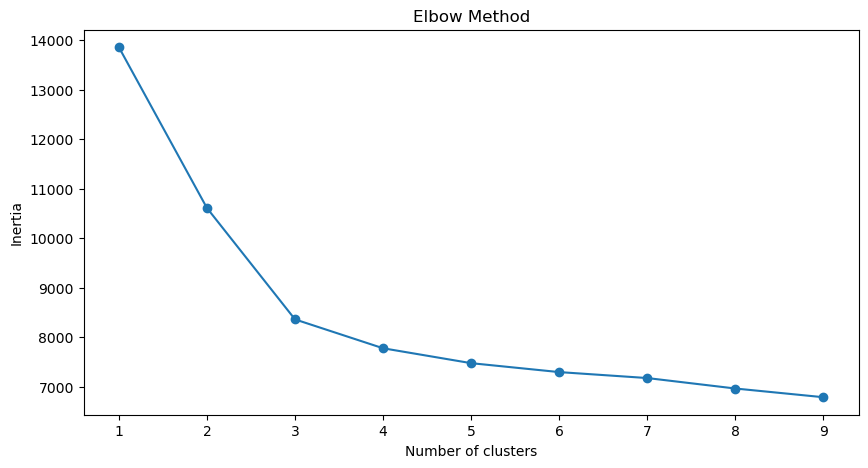

In [136]:
# Import kmeans from sklearn
from sklearn.cluster import KMeans

inertia = []

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(features_unlabled)
    inertia.append(kmeans.inertia_)

# Add markers
plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), inertia, marker = 'o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


his plot demonstrates that the inertia decreases sharply between 1 and 3 clusters, indicating a significant improvement in clustering quality as the number of clusters increases. However, after 3 clusters, the rate of decrease in inertia slows down considerably, suggesting diminishing returns in adding more clusters. This change in slope, often referred to as the "elbow" point, is where adding additional clusters no longer results in a substantial reduction in inertia. Based on this observation, we have determined that the optimal number of clusters for the unlabeled dataset is 3, as it balances simplicity and clustering effectiveness.

## Different clustering methods

### Clustering method 1


In [137]:
# Explanation

### Clustering method 2


In [138]:
# Explanation

### 3. Gaussian Mixture Model (GMM)


Gaussian Mixture Model (GMM)

A Gaussian distribution is just a bell curve defined by:

- Mean μ: Where the center of the curve is.
- Variance (σ2): How wide the curve is.

For multiple features (like in our dataset), the Gaussian becomes multi-dimensional, shaped like an ellipsoid.

**Mixing Gaussians:**

GMM assumes the data is made up of multiple Gaussians combined together.

Each Gaussian has:

- A mean (μk): The center of the cluster.
- A covariance (Σ𝑘): The shape and size of the cluster.
- A weight (𝜋𝑘): How much this Gaussian contributes to the overall data.

**How it finds clusters:**

GMM uses a process called Expectation-Maximization (EM) to figure out:
- Where the centers (𝜇𝑘) are.
- How wide or narrow (Σ𝑘) each cluster is.
- How much each Gaussian contributes (𝜋𝑘).

Steps of EM:
- E-Step: Calculate probabilities for each data point belonging to each cluster.
- M-Step: Update the cluster centers, sizes, and weights based on those probabilities.
- This repeats until the clusters stop changing.

GMM doesn’t just say, “this point is in Cluster A or B.” Instead, it gives probabilities. For example:
“This song has a 70% chance of being Jazz and 30% chance of being Rock.” This is what we call soft clustering

Cluster using Gaussian mixture model. (n.d.). https://nl.mathworks.com/help/stats/clustering-using-gaussian-mixture-models.html

Jordan, J. (2017, October 18). Soft clustering with Gaussian mixed models (EM). Jeremy Jordan. https://www.jeremyjordan.me/gaussian-mixed-models/

## Applying clustering to unlabeled dataset

We will apply the ... clustering method to the unlabeled dataset and incorporate the cluster IDs into it.

In [139]:
# Separating the labeled dataset into features and file_name, so clustering can be applied to the features only
# features_labeled = audio_features_labeled.drop(['file_name', 'genre'], axis=1)  
# labels_labeled = audio_features_labeled[['file_name', 'genre']] 


In [140]:
#KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=0)

kmeans.fit_predict(features_unlabled)

audio_features_unlabeled['cluster'] = kmeans.labels_

audio_features_unlabeled['cluster'].value_counts()


cluster
1    40
0    36
2    29
Name: count, dtype: int64

## Comparing the features of the clusters with the labeled data

In [141]:
display(audio_features_unlabeled.head())
display(audio_features_labeled.head())

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,mfcc_mean_11,mfcc_mean_12,mfcc_var_0,mfcc_var_1,mfcc_var_2,mfcc_var_3,mfcc_var_4,mfcc_var_5,mfcc_var_6,mfcc_var_7,mfcc_var_8,mfcc_var_9,mfcc_var_10,mfcc_var_11,mfcc_var_12,mfcc_delta_mean_0,mfcc_delta_mean_1,mfcc_delta_mean_2,mfcc_delta_mean_3,mfcc_delta_mean_4,mfcc_delta_mean_5,mfcc_delta_mean_6,mfcc_delta_mean_7,mfcc_delta_mean_8,mfcc_delta_mean_9,mfcc_delta_mean_10,mfcc_delta_mean_11,mfcc_delta_mean_12,mfcc_delta_var_0,mfcc_delta_var_1,mfcc_delta_var_2,mfcc_delta_var_3,mfcc_delta_var_4,mfcc_delta_var_5,mfcc_delta_var_6,mfcc_delta_var_7,mfcc_delta_var_8,mfcc_delta_var_9,mfcc_delta_var_10,mfcc_delta_var_11,mfcc_delta_var_12,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var,spectral_flux_mean,spectral_flux_var,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_contrast_var_0,spectral_contrast_var_1,spectral_contrast_var_2,spectral_contrast_var_3,spectral_contrast_var_4,spectral_contrast_var_5,spectral_contrast_var_6,envelope_mean,envelope_var,spectral_bandwidth_mean,spectral_bandwidth_var,rms_mean,rms_var,energy,amplitude_mean,amplitude_var,dynamic_range,tempo_0,beat_strength_mean,beat_strength_var,ibi_var,ibi_mean,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,chroma_var_0,chroma_var_1,chroma_var_2,chroma_var_3,chroma_var_4,chroma_var_5,chroma_var_6,chroma_var_7,chroma_var_8,chroma_var_9,chroma_var_10,chroma_var_11,tonnetz_mean_0,tonnetz_mean_1,tonnetz_mean_2,tonnetz_mean_3,tonnetz_mean_4,tonnetz_mean_5,tonnetz_var_0,tonnetz_var_1,tonnetz_var_2,tonnetz_var_3,tonnetz_var_4,tonnetz_var_5,hpr,harmonic_energy,percussive_energy,zcr_mean,zcr_var,onset_acf_mean,onset_acf_var,skewness,kurtosis,file_name,cluster
0,0.484843,-0.044343,-0.954427,2.103929,-0.224551,0.782247,-0.633407,0.963632,-1.802127,0.800769,-0.702849,1.489750,-1.685808,-0.849299,-0.886708,-0.429886,-0.086896,-0.779328,-0.578764,-0.435047,-0.721065,-0.617533,-0.877221,-0.534277,-0.438833,-0.593892,0.315210,-0.282801,0.782930,0.428510,-0.612612,0.769700,-1.106698,0.798016,-1.152041,0.740150,-0.692571,0.376060,-0.303041,-0.071532,-0.236365,0.302413,0.325005,-0.183306,-0.000106,0.460045,0.347694,0.241812,-0.014767,0.112215,0.699593,0.375543,-0.118559,-0.606174,-0.205239,-0.593952,-0.074746,-0.090409,-0.581354,-0.790987,-0.681794,-1.164331,-0.906045,-0.218929,1.328664,-1.784950,-0.699839,-0.798646,-1.162598,-0.796160,0.060693,-0.294076,-0.021472,-0.381172,-0.282017,-0.615498,-0.004922,-0.504177,-0.350351,-0.021472,-0.381172,0.024431,0.416822,-0.074746,-0.090409,-0.492028,-0.514535,0.622003,0.352209,-0.051710,-0.213567,0.972177,1.174533,0.844419,0.511160,0.794275,1.529750,1.112159,2.281993,-0.960905,-0.371828,-1.173874,-0.782663,-0.436221,-0.714917,-0.745994,-0.723528,-0.600741,-0.013053,-0.889043,0.967023,0.382534,-0.671463,-0.148957,0.189008,-0.936477,-0.391586,-0.955531,-0.878499,-0.756381,-1.009078,-0.838937,-0.785273,0.086724,-0.507515,-0.129316,0.027176,-0.532003,-0.183933,-0.309140,0.596954,-0.300954,m00003.wav,2
1,1.075508,-0.669990,-0.887878,1.720028,-1.586107,1.483106,-1.131664,1.148806,-0.936560,1.776697,-1.563516,2.141827,-1.148060,-1.179524,-0.932879,-0.728568,-0.768918,-0.989962,-0.853158,-0.565911,-0.786326,-0.760098,-0.845228,-0.718238,-0.536320,-0.832574,0.445558,-0.918053,0.894820,0.575889,0.551047,-0.965901,-1.030945,1.723970,-0.181636,1.401849,0.626117,1.172712,0.462274,-0.986363,-0.724767,-0.175523,-0.346863,-0.169189,-0.297886,0.349959,-0.178939,0.427971,0.100625,0.290514,0.707795,-0.344326,0.616991,-0.664436,0.293636,-0.635108,-0.400487,-0.726402,-0.546851,-1.228923,-0.624693,-1.357181,-1.236755,-0.777897,1.496558,-0.405336,-0.9918

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,mfcc_mean_11,mfcc_mean_12,mfcc_var_0,mfcc_var_1,mfcc_var_2,mfcc_var_3,mfcc_var_4,mfcc_var_5,mfcc_var_6,mfcc_var_7,mfcc_var_8,mfcc_var_9,mfcc_var_10,mfcc_var_11,mfcc_var_12,mfcc_delta_mean_0,mfcc_delta_mean_1,mfcc_delta_mean_2,mfcc_delta_mean_3,mfcc_delta_mean_4,mfcc_delta_mean_5,mfcc_delta_mean_6,mfcc_delta_mean_7,mfcc_delta_mean_8,mfcc_delta_mean_9,mfcc_delta_mean_10,mfcc_delta_mean_11,mfcc_delta_mean_12,mfcc_delta_var_0,mfcc_delta_var_1,mfcc_delta_var_2,mfcc_delta_var_3,mfcc_delta_var_4,mfcc_delta_var_5,mfcc_delta_var_6,mfcc_delta_var_7,mfcc_delta_var_8,mfcc_delta_var_9,mfcc_delta_var_10,mfcc_delta_var_11,mfcc_delta_var_12,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var,spectral_flux_mean,spectral_flux_var,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_contrast_var_0,spectral_contrast_var_1,spectral_contrast_var_2,spectral_contrast_var_3,spectral_contrast_var_4,spectral_contrast_var_5,spectral_contrast_var_6,envelope_mean,envelope_var,spectral_bandwidth_mean,spectral_bandwidth_var,rms_mean,rms_var,energy,amplitude_mean,amplitude_var,dynamic_range,tempo_0,beat_strength_mean,beat_strength_var,ibi_var,ibi_mean,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,chroma_var_0,chroma_var_1,chroma_var_2,chroma_var_3,chroma_var_4,chroma_var_5,chroma_var_6,chroma_var_7,chroma_var_8,chroma_var_9,chroma_var_10,chroma_var_11,tonnetz_mean_0,tonnetz_mean_1,tonnetz_mean_2,tonnetz_mean_3,tonnetz_mean_4,tonnetz_mean_5,tonnetz_var_0,tonnetz_var_1,tonnetz_var_2,tonnetz_var_3,tonnetz_var_4,tonnetz_var_5,hpr,harmonic_energy,percussive_energy,zcr_mean,zcr_var,onset_acf_mean,onset_acf_var,skewness,kurtosis,file_name,genre
0,-1.498492,0.463125,0.935340,-0.414501,-0.456621,0.172973,-0.548461,0.153939,-0.153653,0.691429,0.192370,-0.480569,0.140689,-0.758581,-0.517734,-0.385309,-0.826040,-0.647575,-0.783254,-0.427653,-0.905687,-0.878320,-0.237821,1.033750,1.811082,1.367828,0.078794,0.333609,0.627904,1.232110,-0.029408,0.047448,0.895585,-0.046777,-0.087751,-0.996213,-0.634945,-0.303659,0.755015,-0.713504,-0.722282,-0.679644,-0.900618,-0.695678,-0.700372,-1.125969,-1.123366,-1.152810,-1.006162,-0.709476,-0.240407,-0.772849,-1.091371,-0.545908,-1.008337,0.096692,-1.053482,-0.686828,-0.357985,1.924882,2.133247,2.261729,1.608506,0.527621,0.437552,0.224502,2.913952,1.822707,1.684442,0.992515,-0.374940,-0.279623,-1.109602,-0.902356,-0.609386,-0.026183,-1.148651,-0.632129,-0.882529,-1.109602,-0.902356,-1.748365,0.556581,-1.053482,-0.686828,-0.001557,-0.539609,-1.443746,-1.192786,-0.418361,-0.617586,-1.304390,-1.110448,-1.266352,-1.371965,-0.331364,-1.163196,-1.607964,-2.039455,0.372305,0.318671,2.284660,1.489352,0.447067,1.386773,0.642377,1.459680,3.061542,1.339954,-0.225283,0.457514,-0.117745,0.299455,0.007619,0.270016,-3.522461,-0.198165,4.233745,1.660874,1.653322,2.793648,2.388165,1.375820,-0.194075,-0.660256,-0.895169,-1.392931,-0.722963,-0.952711,-0.612828,0.606343,0.020338,m00002.wav,jazz
1,-0.211600,0.404914,0.229862,0.415860,0.081080,1.094913,-0.799305,0.183916,-0.491156,-0.023165,-0.324015,0.721317,-0.430791,1.258372,1.731422,0.145238,1.328978,0.861547,0.663098,2.942315,1.389736,2.768872,1.694204,0.794348,0.351416,0.630096,0.709611,-0.559317,-0.827747,0.449534,-0.202843,-0.138750,-0.013551,-1.064572,-1.032716,-0.996794,0.620274,1.552873,-0.385767,1.515704,1.339192,0.365229,1.225769,1.312889,0.590719,2.852363,1.560836,3.101131,2.228655,1.271021,0.689383,1.278210,-0.573187,0.519222,-0.468738,0.780515,1.216447,1.701756,-0.281627,0.510023,0.549347,0.044033,0.522903,0.042418,0.757910,1.128213,0.308056,1.318851,0.528492,1.259734,0.8056

In [142]:
# make a randomizer that selects 2 random colums

# Randomly select 2 columns
random_columns = np.random.choice(features_unlabeled.columns, size=2, replace=False)

random_columns

array(['spectral_contrast_var_3', 'spectral_centroid_var'], dtype=object)

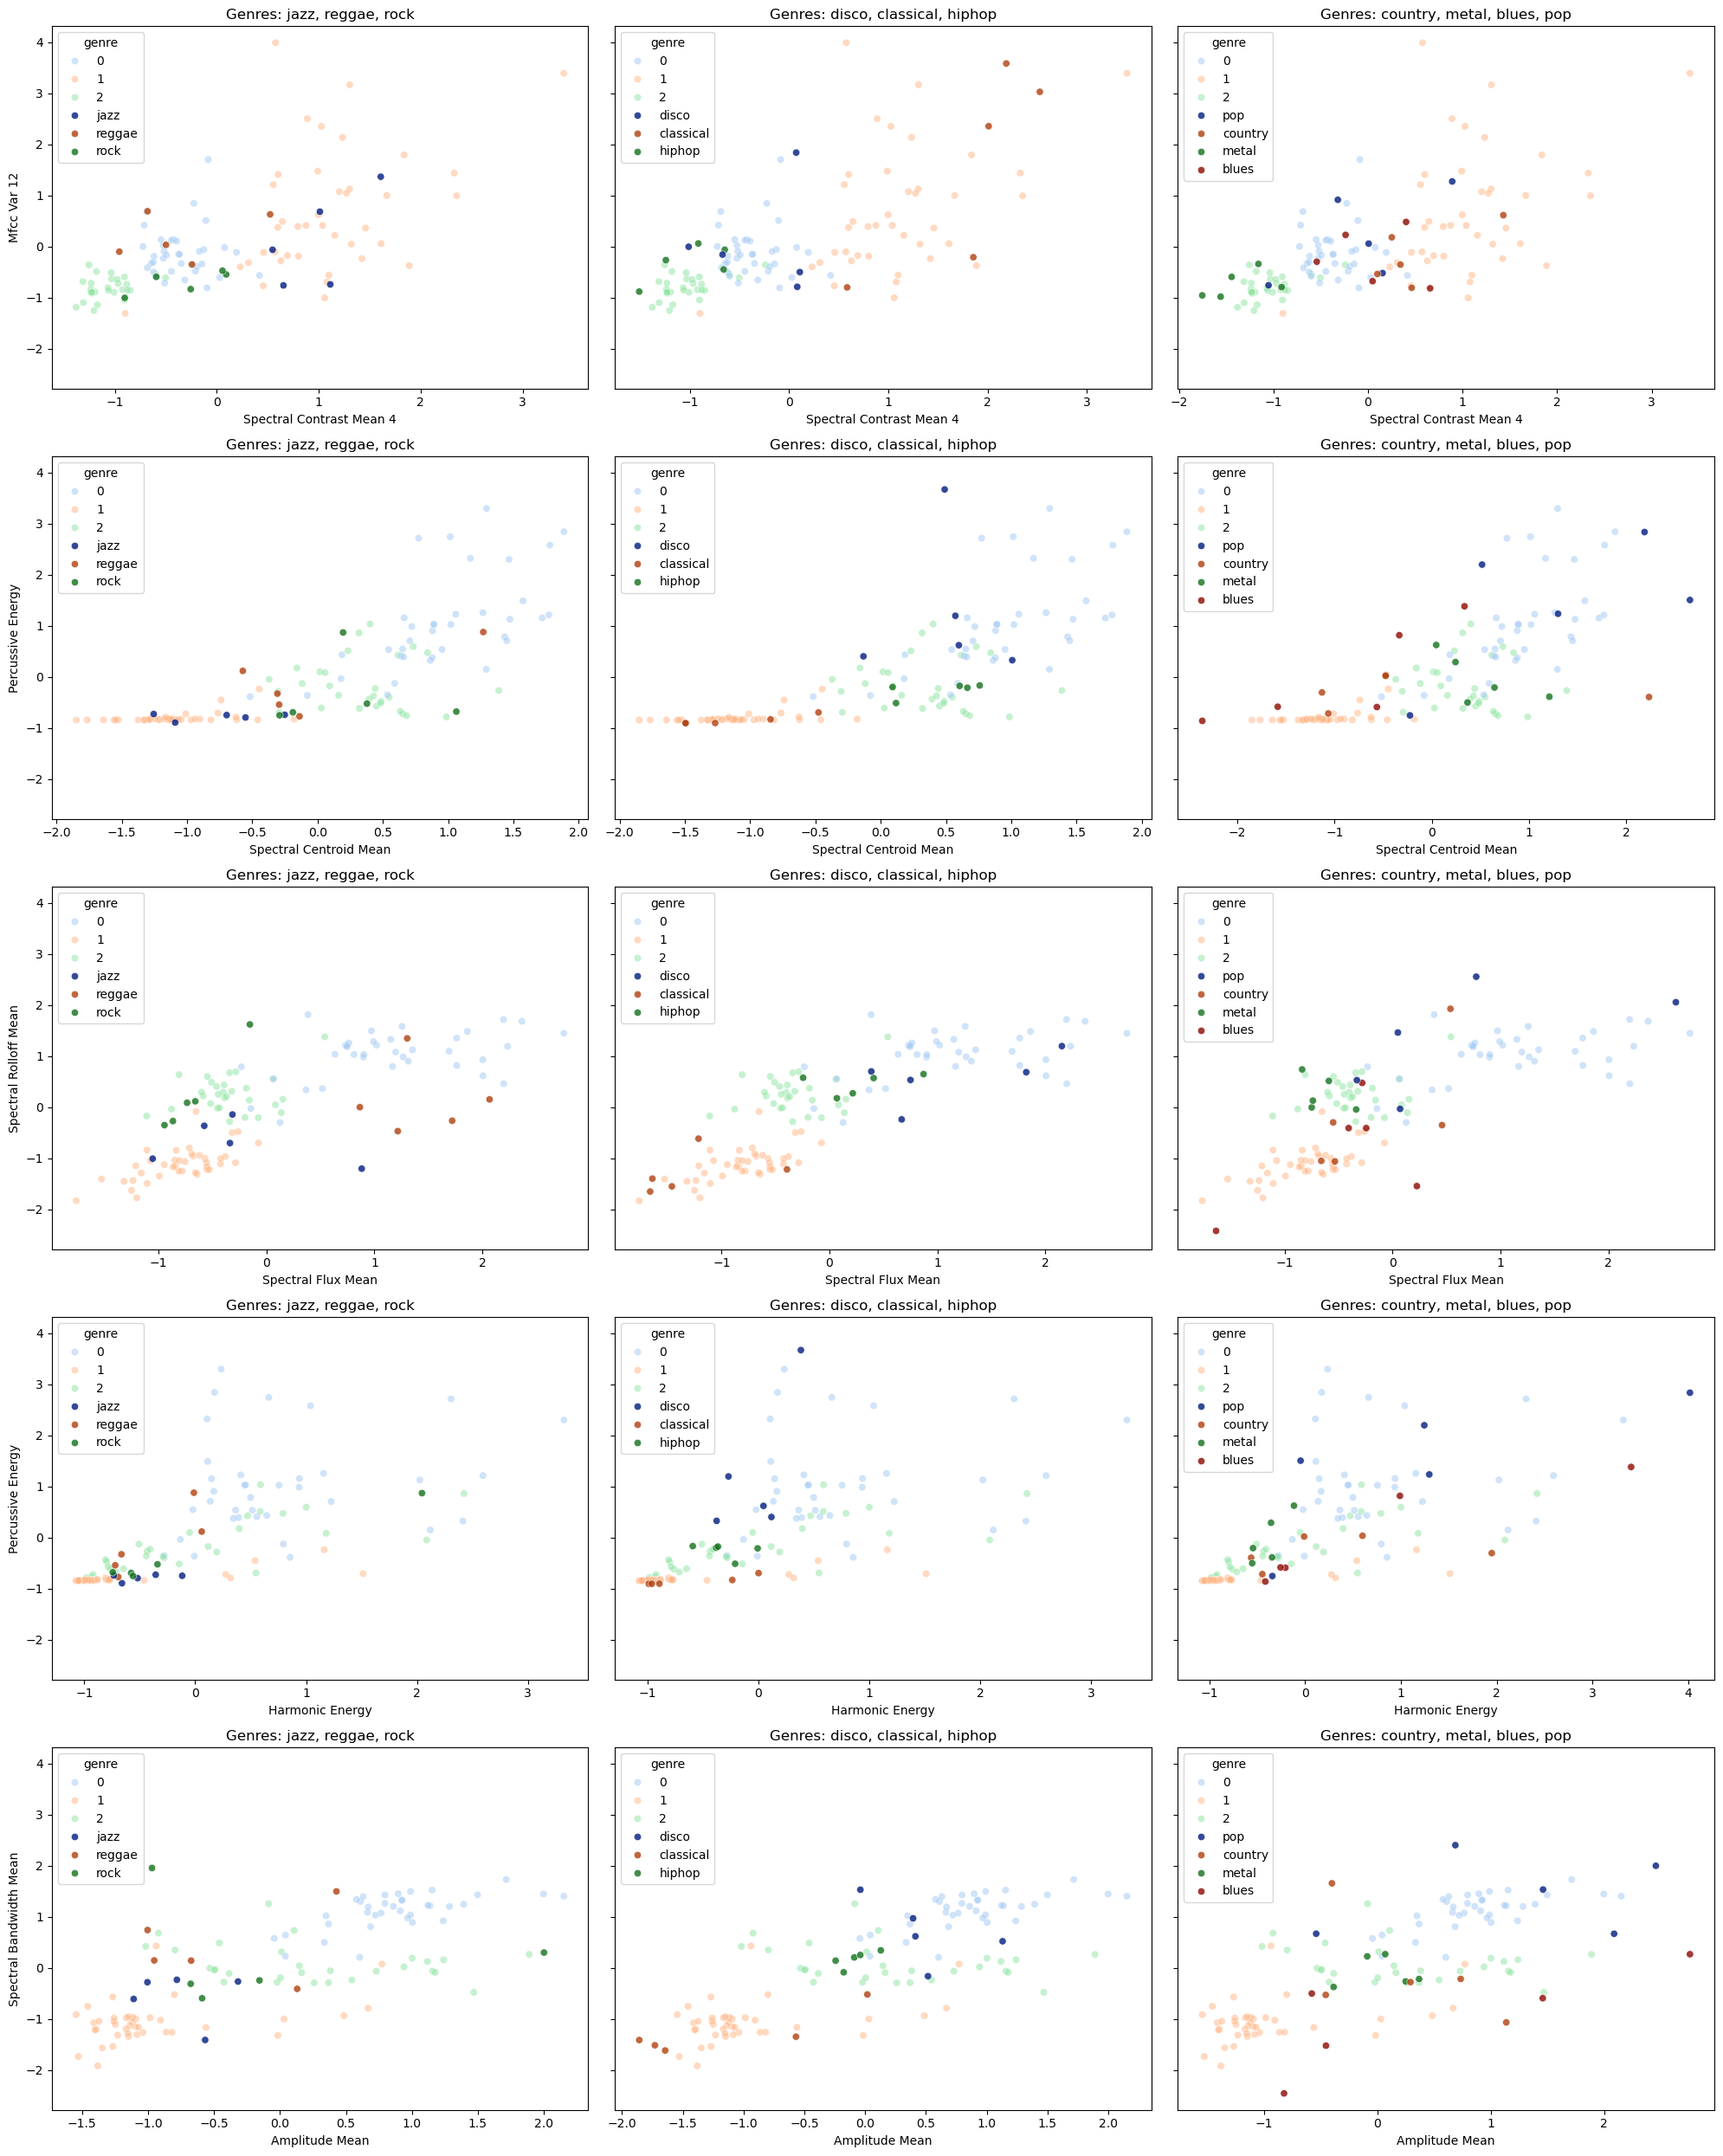

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define genre groups
genre_groups = [
    ['jazz', 'reggae', 'rock'],  # Group 1
    ['disco', 'classical', 'hiphop'],  # Group 2
    ['country', 'metal', 'blues', 'pop']  # Group 3
]

# Define feature combinations
feature_combinations = [
    ('spectral_contrast_mean_4', 'mfcc_var_12'),
    ('spectral_centroid_mean', 'percussive_energy'),
    ('spectral_flux_mean', 'spectral_rolloff_mean'),
    ('harmonic_energy', 'percussive_energy'),
    ('amplitude_mean', 'spectral_bandwidth_mean'),
    
]

# Generate palettes
cluster_palette = sns.color_palette("pastel", as_cmap=False)  # Light colors for clusters
genre_palette = sns.color_palette("dark", as_cmap=False)  # Dark colors for genres

# Set up the subplots (rows for feature combinations, columns for genre groups)
fig, axes = plt.subplots(len(feature_combinations), len(genre_groups), figsize=(20, 25), sharex=False, sharey=True)

# Plot for each combination of feature set and genre group
for row, (x_feature, y_feature) in enumerate(feature_combinations):
    for col, genres in enumerate(genre_groups):
        # Filter labeled data for the current genre group
        filtered_labeled = audio_features_labeled[audio_features_labeled['genre'].isin(genres)]
        
        # Scatterplot for clusters (unlabeled data)
        sns.scatterplot(
            x=audio_features_unlabeled[x_feature],
            y=audio_features_unlabeled[y_feature],
            hue=audio_features_unlabeled['cluster'],
            palette=cluster_palette,  # Light colors for clusters
            alpha=0.5,
            ax=axes[row, col],
            legend=True  # Suppress the cluster legend for now
        )
        
        # Scatterplot for the current genre group
        sns.scatterplot(
            x=filtered_labeled[x_feature],
            y=filtered_labeled[y_feature],
            hue=filtered_labeled['genre'],
            palette=genre_palette,  # Dark colors for genres
            alpha=0.8,
            ax=axes[row, col],
            legend=True  # Suppress the genre legend for now
        )
        
        # Titles and axis labels
        axes[row, col].set_title(f"Genres: {', '.join(genres)}")
        axes[row, col].set_xlabel(x_feature.replace('_', ' ').title())
        axes[row, col].set_ylabel(y_feature.replace('_', ' ').title())

# Adjust layout
plt.tight_layout()
plt.show()

# cluster 0 disco of raggae
# cluster 1 is classical
# cluster 2 is metal of hiphop


## Dimensionality reduction

### Principal Component Analysis (PCA)

In [173]:
# Apply pca to the unlabeled data

from sklearn.decomposition import PCA

# Initialize PCA

pca = PCA(n_components=10)

# Fit and transform the data

pca_features = pca.fit_transform(features_unlabeled)

# Create a DataFrame for the PCA features

pca_df = pd.DataFrame(data=pca_features, columns=[f'PC{i}' for i in range(1, 11)])

pca_df.head()



,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,0.570485,6.727344,1.381421,0.990569,1.478328,-1.055877,0.624425,-0.817456,1.088959,-0.026847
1,0.946251,8.068952,0.737468,1.241307,0.965620,2.751765,0.959640,-0.424107,-0.855570,0.937023
2,-4.933975,0.682810,2.204425,1.854089,3.734956,-0.330935,0.404516,0.571983,-0.775578,2.712496
3,0.980685,6.510541,-0.078757,1.064019,0.536647,-2.381409,0.040751,-0.063133,1.487425,0.251969
4,-6.463436,-4.958431,-2.534463,4.563079,2.423348,1.327214,-2.778462,-0.854993,0.243518,0.329950


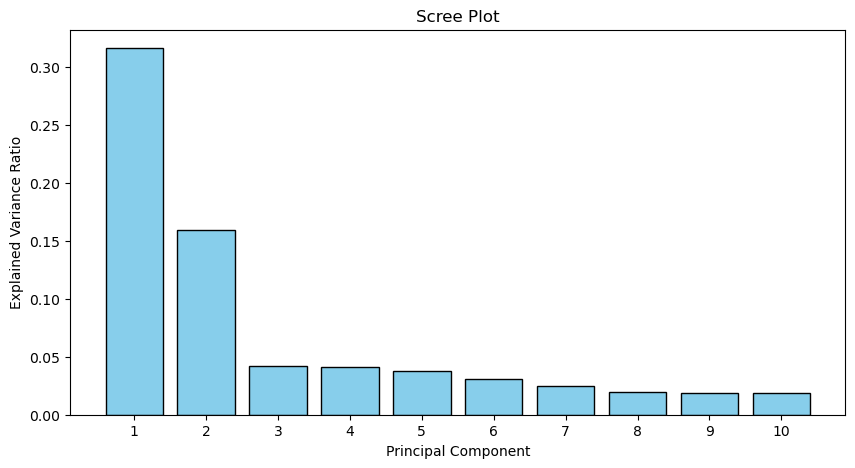

In [172]:
import matplotlib.pyplot as plt

# Assuming `pca.explained_variance_ratio_` is already computed

plt.figure(figsize=(10, 5))

# Use a bar plot instead of a line plot
plt.bar(range(1, 11), pca.explained_variance_ratio_, color='skyblue', edgecolor='black')

plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, 11))  # Set x-ticks to match the principal components

plt.show()


### Non-Negative Matrix Factorization (NMF)

## Reapplying clustering method new dataset

## Conclusion

### Feature importance

### Effect dimensionality reduction

### What additional data would improve the accuracy of predictions?